# Chart Export Notebook

This notebook provides utilities to:
1. **Render all unique chart types individually** for easy PNG export
2. **Extract individual charts from grid layouts** as separate figure objects
3. **Export any chart as PNG** with high quality settings

## Chart Types Available

### Single Lender Charts
1. **Aggregate Waterfall** - Simple waterfall showing overall decomposition
2. **Dimensional Stacked Waterfall** - Waterfall with stacked bars by dimension (FICO, comp tier, prod line)
3. **Dimension Drilldown** - Horizontal bar charts showing effect breakdown by dimension

### Multi-Lender Charts
4. **Lender Aggregate Waterfall** - Overall waterfall with lender breakdown
5. **Lender Drilldown** - Horizontal bars showing effects by lender
6. **Lender Waterfall Grid** - 2-panel grid with aggregate + lender breakdown

## Functions Provided

### For Grid Charts
- `extract_individual_charts_from_grid()` - Splits 2x2 grid into 4 separate figures
- `extract_individual_drilldown_charts()` - Splits drilldown into separate effect charts
- `extract_lender_drilldown_charts()` - Splits lender drilldown into separate charts
- `extract_lender_grid_charts()` - Splits 1x2 lender grid into 2 separate figures

### For Individual Chart Rendering
- `create_aggregate_waterfall_standalone()` - Render aggregate waterfall only
- `create_dimensional_waterfall_standalone()` - Render one dimensional waterfall
- `create_single_effect_drilldown()` - Render one effect's dimension breakdown

### For Export
- `export_chart()` - Save any figure as PNG with options

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from typing import List, Optional, Dict

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import symmetric_decomposition_calculator
import visualization_engine
from visualization_engine import (
    COLOR_POSITIVE, COLOR_NEGATIVE, COLOR_TOTAL, COLOR_CONNECTOR,
    _create_aggregate_waterfall, _create_dimensional_waterfall,
    _format_effect_labels, format_number
)

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Sample Data

Load data and calculate decomposition results for demonstration

In [2]:
# Load data
data_path = Path.cwd().parent / 'data' / 'funnel_data_mock_v2.csv'
df = pd.read_csv(data_path)
df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])

# Calculate single-lender decomposition
results = symmetric_decomposition_calculator.calculate_decomposition(
    df=df,
    date_a='2023-06-01',
    date_b='2024-06-01',
    lender='ACA'
)

# Calculate multi-lender decomposition
multi_results = symmetric_decomposition_calculator.calculate_multi_lender_decomposition(
    df=df,
    date_a='2023-06-01',
    date_b='2024-06-01'
)

print("Data loaded and decomposition calculated!")
print(f"Period: {results.metadata['date_a']} → {results.metadata['date_b']}")
print(f"Lenders in multi-lender analysis: {multi_results.metadata['lenders']}")

Calculating decomposition for ACA...
Calculating decomposition for ALY...
Calculating decomposition for CAP...
Data loaded and decomposition calculated!
Period: 2023-06-01 → 2024-06-01
Lenders in multi-lender analysis: ['ACA', 'ALY', 'CAP']


## 2. Utility Functions for Extracting Individual Charts from Grids

In [3]:
def extract_individual_charts_from_grid(
    summary: pd.DataFrame,
    segment_detail: pd.DataFrame,
    lender: str = 'ACA'
) -> List[plt.Figure]:
    """
    Extract individual charts from the 2x2 waterfall grid.
    
    Returns a list of 4 separate figure objects:
    [0] Overall aggregate waterfall
    [1] By FICO bands
    [2] By offer comp tier
    [3] By product line
    
    Parameters
    ----------
    summary : pd.DataFrame
        Lender-level aggregate impacts
    segment_detail : pd.DataFrame
        Segment-level breakdown
    lender : str
        Lender name for chart titles
    
    Returns
    -------
    List[plt.Figure]
        List of 4 figure objects
    """
    # Extract metadata
    date_a = segment_detail['period_1_date'].iloc[0]
    date_b = segment_detail['period_2_date'].iloc[0]
    period_1_bks = segment_detail['period_1_segment_bookings'].sum()
    period_2_bks = segment_detail['period_2_segment_bookings'].sum()
    
    charts = []
    
    # Chart 1: Overall aggregate
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig1.suptitle(
        f'{lender} Booking Decomposition: {date_a} → {date_b}\nOverall Aggregate',
        fontsize=14, fontweight='bold'
    )
    _create_aggregate_waterfall(
        ax=ax1,
        summary=summary,
        period_1_bks=period_1_bks,
        period_2_bks=period_2_bks,
        title='Overall Aggregate'
    )
    plt.tight_layout()
    charts.append(fig1)
    
    # Chart 2: By FICO band
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    fig2.suptitle(
        f'{lender} Booking Decomposition: {date_a} → {date_b}\nBy FICO Band',
        fontsize=14, fontweight='bold'
    )
    _create_dimensional_waterfall(
        ax=ax2,
        summary=summary,
        segment_detail=segment_detail,
        dimension='fico_bands',
        period_1_bks=period_1_bks,
        period_2_bks=period_2_bks,
        title='By FICO Band'
    )
    plt.tight_layout()
    charts.append(fig2)
    
    # Chart 3: By offer comp tier
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    fig3.suptitle(
        f'{lender} Booking Decomposition: {date_a} → {date_b}\nBy Offer Comp Tier',
        fontsize=14, fontweight='bold'
    )
    _create_dimensional_waterfall(
        ax=ax3,
        summary=summary,
        segment_detail=segment_detail,
        dimension='offer_comp_tier',
        period_1_bks=period_1_bks,
        period_2_bks=period_2_bks,
        title='By Offer Comp Tier'
    )
    plt.tight_layout()
    charts.append(fig3)
    
    # Chart 4: By product line
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.suptitle(
        f'{lender} Booking Decomposition: {date_a} → {date_b}\nBy Product Line',
        fontsize=14, fontweight='bold'
    )
    _create_dimensional_waterfall(
        ax=ax4,
        summary=summary,
        segment_detail=segment_detail,
        dimension='prod_line',
        period_1_bks=period_1_bks,
        period_2_bks=period_2_bks,
        title='By Product Line'
    )
    plt.tight_layout()
    charts.append(fig4)
    
    return charts


def extract_individual_drilldown_charts(
    segment_detail: pd.DataFrame,
    dimension: str,
    lender: str = 'ACA'
) -> List[plt.Figure]:
    """
    Extract individual effect charts from dimension drilldown.
    
    Returns a list of 7 separate figure objects (one per effect):
    [0] Total net impact
    [1] Volume effect
    [2] Mix effect
    [3] Straight approval effect
    [4] Conditional approval effect
    [5] Straight booking effect
    [6] Conditional booking effect
    
    Parameters
    ----------
    segment_detail : pd.DataFrame
        Segment-level breakdown
    dimension : str
        Dimension to drill into ('fico_bands', 'offer_comp_tier', 'prod_line')
    lender : str
        Lender name for chart titles
    
    Returns
    -------
    List[plt.Figure]
        List of 7 figure objects
    """
    # Extract metadata
    date_a = segment_detail['period_1_date'].iloc[0]
    date_b = segment_detail['period_2_date'].iloc[0]
    
    # Aggregate by dimension
    dim_agg = segment_detail.groupby(dimension).agg({
        'total_effect': 'sum',
        'volume_effect': 'sum',
        'mix_effect': 'sum',
        'str_approval_effect': 'sum',
        'cond_approval_effect': 'sum',
        'str_booking_effect': 'sum',
        'cond_booking_effect': 'sum'
    }).reset_index()
    
    effects = [
        ('total_effect', 'Total Net Impact'),
        ('volume_effect', 'Volume Effect'),
        ('mix_effect', 'Mix Effect'),
        ('str_approval_effect', 'Straight Approval Effect'),
        ('cond_approval_effect', 'Conditional Approval Effect'),
        ('str_booking_effect', 'Straight Booking Effect'),
        ('cond_booking_effect', 'Conditional Booking Effect')
    ]
    
    charts = []
    
    for effect_col, title in effects:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get data
        data = dim_agg[[dimension, effect_col]].sort_values(effect_col, ascending=False)
        
        # Colors based on positive/negative
        colors = [COLOR_POSITIVE if val >= 0 else COLOR_NEGATIVE
                 for val in data[effect_col]]
        
        # Plot bars
        bars = ax.barh(data[dimension], data[effect_col], color=colors,
                      edgecolor='black', linewidth=1)
        
        # Calculate x-axis limits with padding for labels
        max_val = data[effect_col].max()
        min_val = data[effect_col].min()
        val_range = max_val - min_val
        
        # Handle case where all values are zero or very close to zero
        if abs(max_val) < 0.01 and abs(min_val) < 0.01:
            x_min = -10
            x_max = 10
        else:
            # Add 15% padding on each side for labels
            padding = max(val_range * 0.15, abs(max_val) * 0.1, abs(min_val) * 0.1, 10)
            x_min = min_val - padding if min_val < 0 else -padding * 0.3
            x_max = max_val + padding if max_val > 0 else padding * 0.3
        
        # Value labels
        for i, (val, dim_val) in enumerate(zip(data[effect_col], data[dimension])):
            sign = '+' if val >= 0 else ''
            if val >= 0:
                label_x = val
                label_text = f'  {sign}{format_number(val, 0)}'
                h_align = 'left'
            else:
                offset = abs(x_max - x_min) * 0.01
                label_x = val - offset
                label_text = f'{sign}{format_number(val, 0)} '
                h_align = 'right'
            
            ax.text(label_x, i, label_text,
                   va='center', ha=h_align,
                   fontsize=10, fontweight='bold')
        
        # Formatting
        ax.set_xlabel('Booking Impact', fontsize=10, fontweight='bold')
        ax.set_title(
            f'{lender} - {title}\nBy {dimension.replace("_", " ").title()}\n{date_a} → {date_b}',
            fontsize=11, fontweight='bold', pad=10
        )
        ax.set_xlim(x_min, x_max)
        ax.axvline(x=0, color='black', linewidth=0.8)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        charts.append(fig)
    
    return charts


def extract_lender_drilldown_charts(
    lender_summaries: pd.DataFrame,
    date_a: str,
    date_b: str
) -> List[plt.Figure]:
    """
    Extract individual effect charts from lender drilldown.
    
    Returns a list of 6 separate figure objects (one per effect):
    [0] Volume effect
    [1] Mix effect
    [2] Straight approval effect
    [3] Conditional approval effect
    [4] Straight booking effect
    [5] Conditional booking effect
    
    Parameters
    ----------
    lender_summaries : pd.DataFrame
        Lender-level summaries from MultiLenderDecompositionResults
    date_a : str
        Period 1 date
    date_b : str
        Period 2 date
    
    Returns
    -------
    List[plt.Figure]
        List of 6 figure objects
    """
    effects_to_plot = [
        ('volume_effect', 'Volume Effect'),
        ('mix_effect', 'Mix Effect'),
        ('str_approval_effect', 'Straight Approval Effect'),
        ('cond_approval_effect', 'Conditional Approval Effect'),
        ('str_booking_effect', 'Straight Booking Effect'),
        ('cond_booking_effect', 'Conditional Booking Effect')
    ]
    
    charts = []
    
    for effect_type, effect_label in effects_to_plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get data for this effect
        effect_data = lender_summaries[lender_summaries['effect_type'] == effect_type].copy()
        effect_data = effect_data.sort_values('booking_impact', ascending=True)
        
        # Separate positive and negative
        positive = effect_data[effect_data['booking_impact'] > 0]
        negative = effect_data[effect_data['booking_impact'] < 0]
        
        # Plot
        if not negative.empty:
            bars_neg = ax.barh(negative['lender'], negative['booking_impact'],
                               color='#EF5350', edgecolor='black', linewidth=0.5)
            for bar in bars_neg:
                width = bar.get_width()
                if width != 0:
                    ax.text(width, bar.get_y() + bar.get_height() / 2,
                            f'{width:+.0f}', ha='right' if width < 0 else 'left',
                            va='center', fontweight='bold', fontsize=9)
        
        if not positive.empty:
            bars_pos = ax.barh(positive['lender'], positive['booking_impact'],
                               color='#66BB6A', edgecolor='black', linewidth=0.5)
            for bar in bars_pos:
                width = bar.get_width()
                if width != 0:
                    ax.text(width, bar.get_y() + bar.get_height() / 2,
                            f'{width:+.0f}', ha='right' if width < 0 else 'left',
                            va='center', fontweight='bold', fontsize=9)
        
        # Calculate total for this effect
        total_impact = effect_data['booking_impact'].sum()
        
        # Title
        ax.set_title(
            f'Multi-Lender - {effect_label}\n{date_a} → {date_b}\n(Total: {total_impact:+,.0f})',
            fontsize=11, fontweight='bold', pad=10
        )
        
        # Formatting
        ax.set_xlabel('Booking Impact', fontsize=10, fontweight='bold')
        ax.axvline(x=0, color='black', linewidth=0.8)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Set x-axis limits with some padding
        if not effect_data.empty:
            x_max = max(abs(effect_data['booking_impact'].min()), abs(effect_data['booking_impact'].max()))
            x_max = x_max * 1.2
            ax.set_xlim(-x_max, x_max)
        
        plt.tight_layout()
        charts.append(fig)
    
    return charts


def extract_lender_grid_charts(
    lender_summaries: pd.DataFrame,
    aggregate_summary: pd.DataFrame,
    metadata: dict
) -> List[plt.Figure]:
    """
    Extract individual charts from the 1x2 lender waterfall grid.
    
    Returns a list of 2 separate figure objects:
    [0] Overall aggregate waterfall
    [1] By lender (stacked waterfall)
    
    Parameters
    ----------
    lender_summaries : pd.DataFrame
        Lender-level summaries
    aggregate_summary : pd.DataFrame
        Aggregate summary
    metadata : dict
        Metadata from MultiLenderDecompositionResults
    
    Returns
    -------
    List[plt.Figure]
        List of 2 figure objects
    """
    date_a = metadata['date_a']
    date_b = metadata['date_b']
    period_1_bks = metadata['aggregate_period_1_bookings']
    period_2_bks = metadata['aggregate_period_2_bookings']
    lenders = metadata['lenders']
    
    charts = []
    
    # Chart 1: Overall aggregate
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig1.suptitle(
        f'Multi-Lender Booking Decomposition: {date_a} → {date_b}\nOverall Aggregate',
        fontsize=14, fontweight='bold'
    )
    _create_aggregate_waterfall(
        ax=ax1,
        summary=aggregate_summary,
        period_1_bks=period_1_bks,
        period_2_bks=period_2_bks,
        title='Overall Aggregate'
    )
    plt.tight_layout()
    charts.append(fig1)
    
    # Chart 2: By lender - we'll reuse the lender aggregate waterfall creation logic
    # Chart 2: By lender - use updated function with proper parameters
    fig2 = visualization_engine.create_lender_aggregate_waterfall(
        lender_summaries=lender_summaries,
        aggregate_summary=aggregate_summary,
        date_a=date_a,
        date_b=date_b,
        period_1_bks=period_1_bks,
        period_2_bks=period_2_bks
    )
    charts.append(fig2)
    
    return charts


print("Extraction functions defined successfully!")

Extraction functions defined successfully!


## 3. Export Utility Function

In [4]:
def export_chart(
    fig: plt.Figure,
    filename: str,
    output_dir: str = '../output/charts',
    dpi: int = 300,
    bbox_inches: str = 'tight',
    format: str = 'png'
) -> Path:
    """
    Export a matplotlib figure to file.
    
    Parameters
    ----------
    fig : plt.Figure
        Figure to export
    filename : str
        Filename (without extension)
    output_dir : str
        Output directory path
    dpi : int
        Resolution in dots per inch (default 300 for high quality)
    bbox_inches : str
        Bounding box setting ('tight' removes whitespace)
    format : str
        File format (png, pdf, svg, etc.)
    
    Returns
    -------
    Path
        Path to saved file
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    file_path = output_path / f"{filename}.{format}"
    fig.savefig(file_path, dpi=dpi, bbox_inches=bbox_inches, format=format)
    
    print(f"Chart exported to: {file_path}")
    return file_path


def export_chart_list(
    charts: List[plt.Figure],
    base_filename: str,
    output_dir: str = '../output/charts',
    dpi: int = 300
) -> List[Path]:
    """
    Export a list of charts with numbered filenames.
    
    Parameters
    ----------
    charts : List[plt.Figure]
        List of figures to export
    base_filename : str
        Base filename (will be appended with _1, _2, etc.)
    output_dir : str
        Output directory path
    dpi : int
        Resolution in dots per inch
    
    Returns
    -------
    List[Path]
        List of paths to saved files
    """
    paths = []
    for i, fig in enumerate(charts, 1):
        filename = f"{base_filename}_{i:02d}"
        path = export_chart(fig, filename, output_dir, dpi)
        paths.append(path)
    
    return paths


print("Export functions defined successfully!")

Export functions defined successfully!


## 4. Example: Extract and Export Individual Charts from Waterfall Grid

This demonstrates how to split the 2x2 grid into 4 separate charts.

Extracted 4 individual charts from the grid:
  [0] Overall Aggregate Waterfall
  [1] By FICO Bands
  [2] By Offer Comp Tier
  [3] By Product Line

You can now:
  - Display them: plt.show() or grid_charts[0].show()
  - Export them: export_chart_list(grid_charts, 'waterfall_grid')
  - Access individually: grid_charts[0], grid_charts[1], etc.


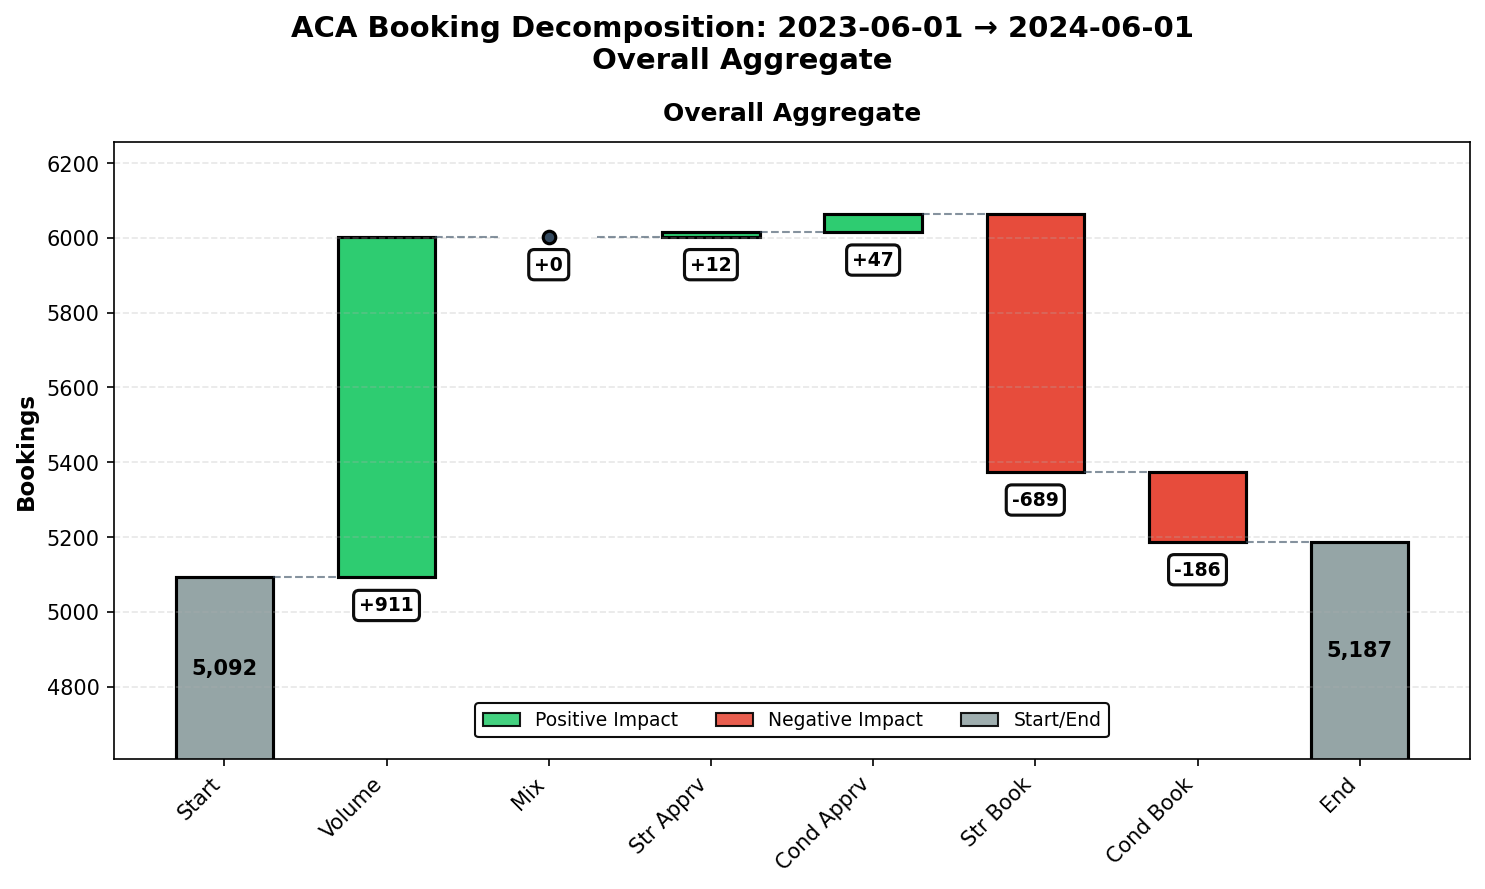

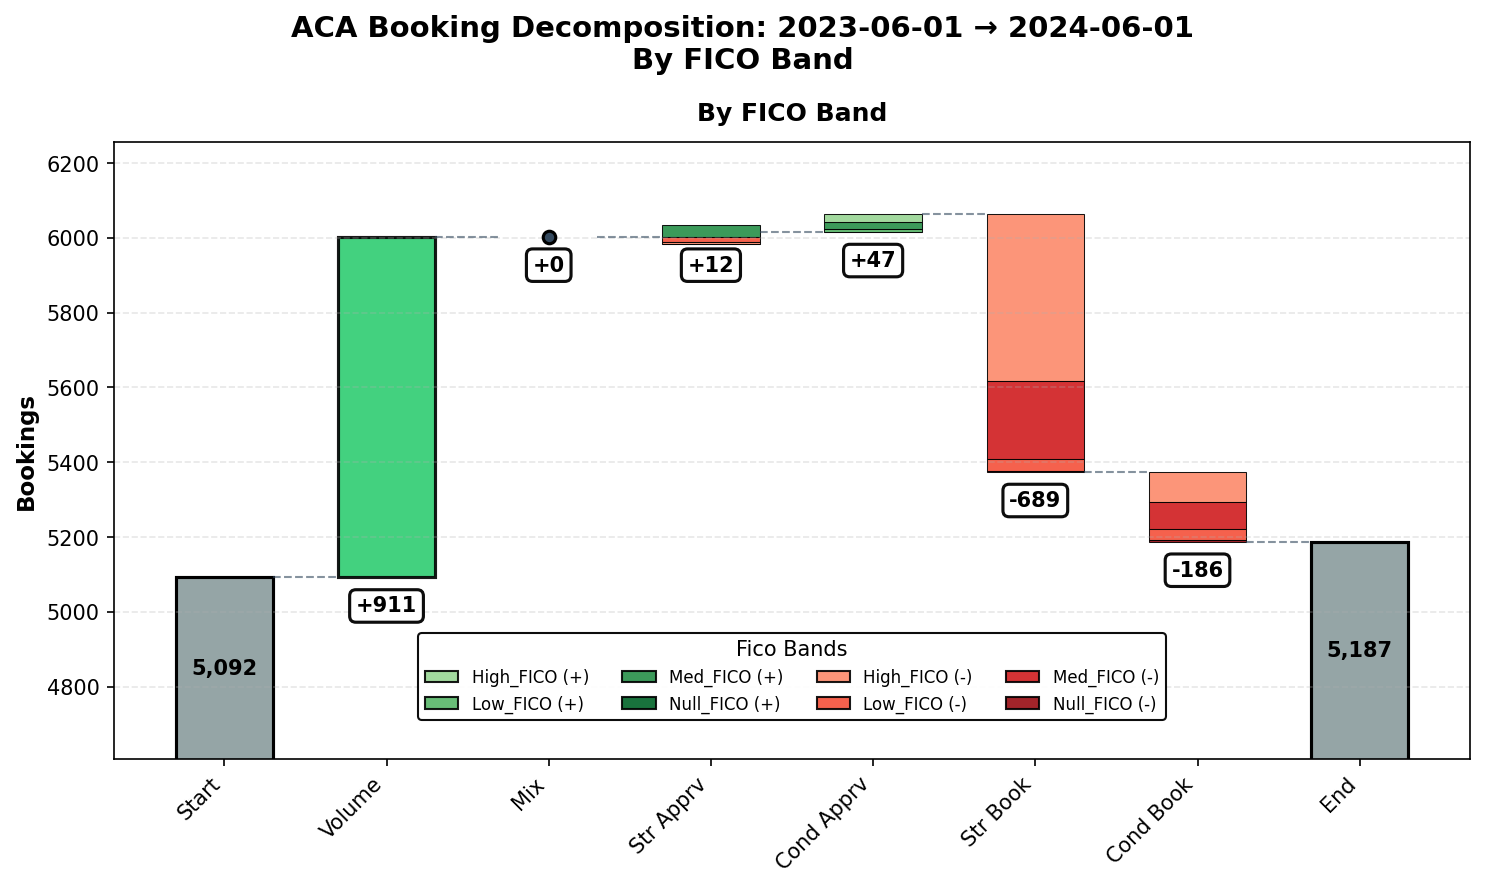

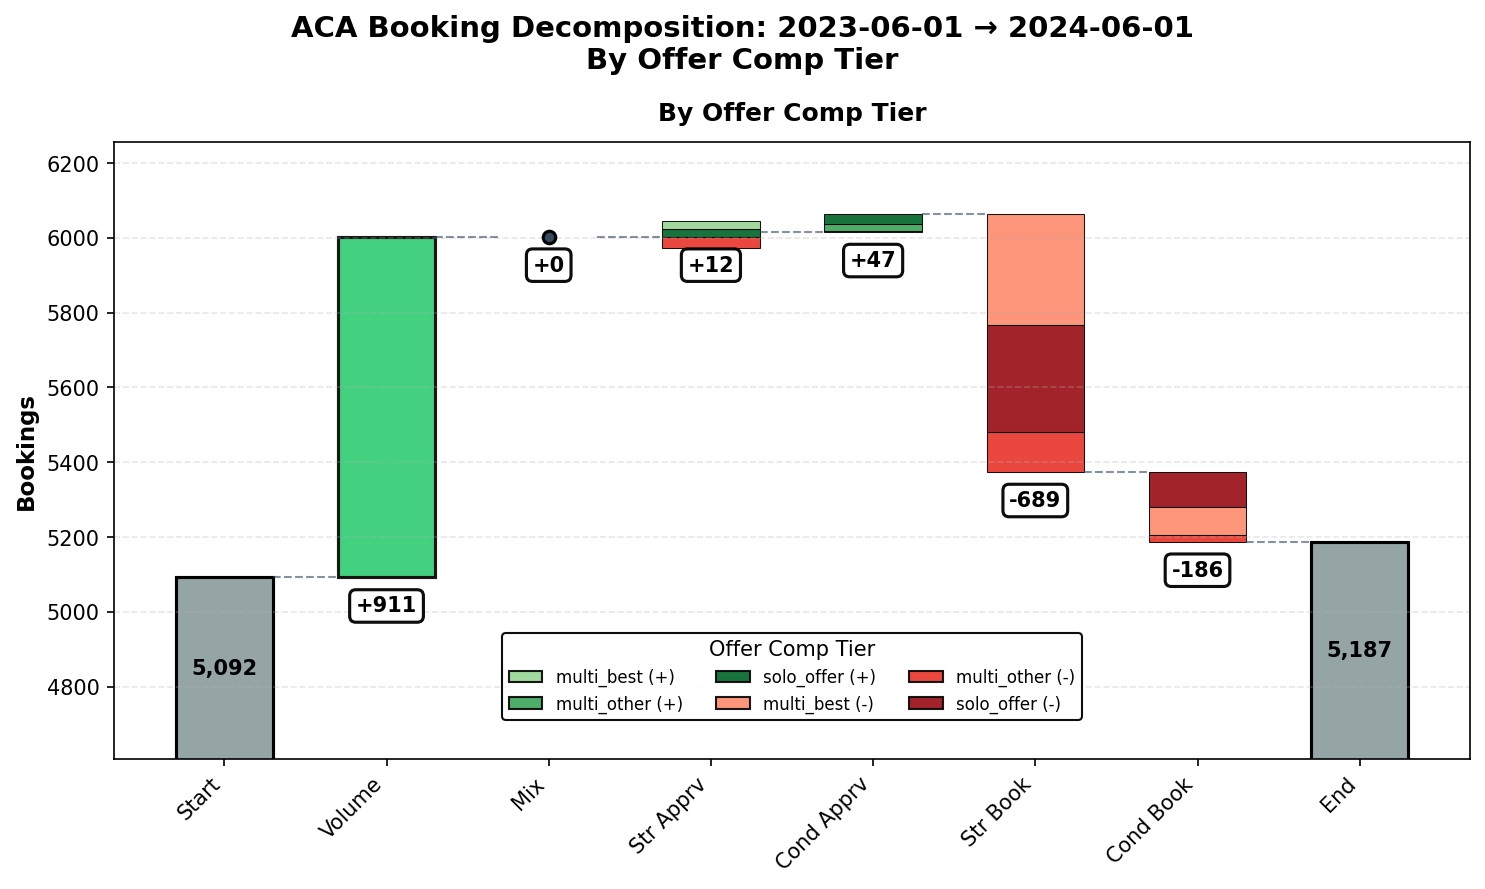

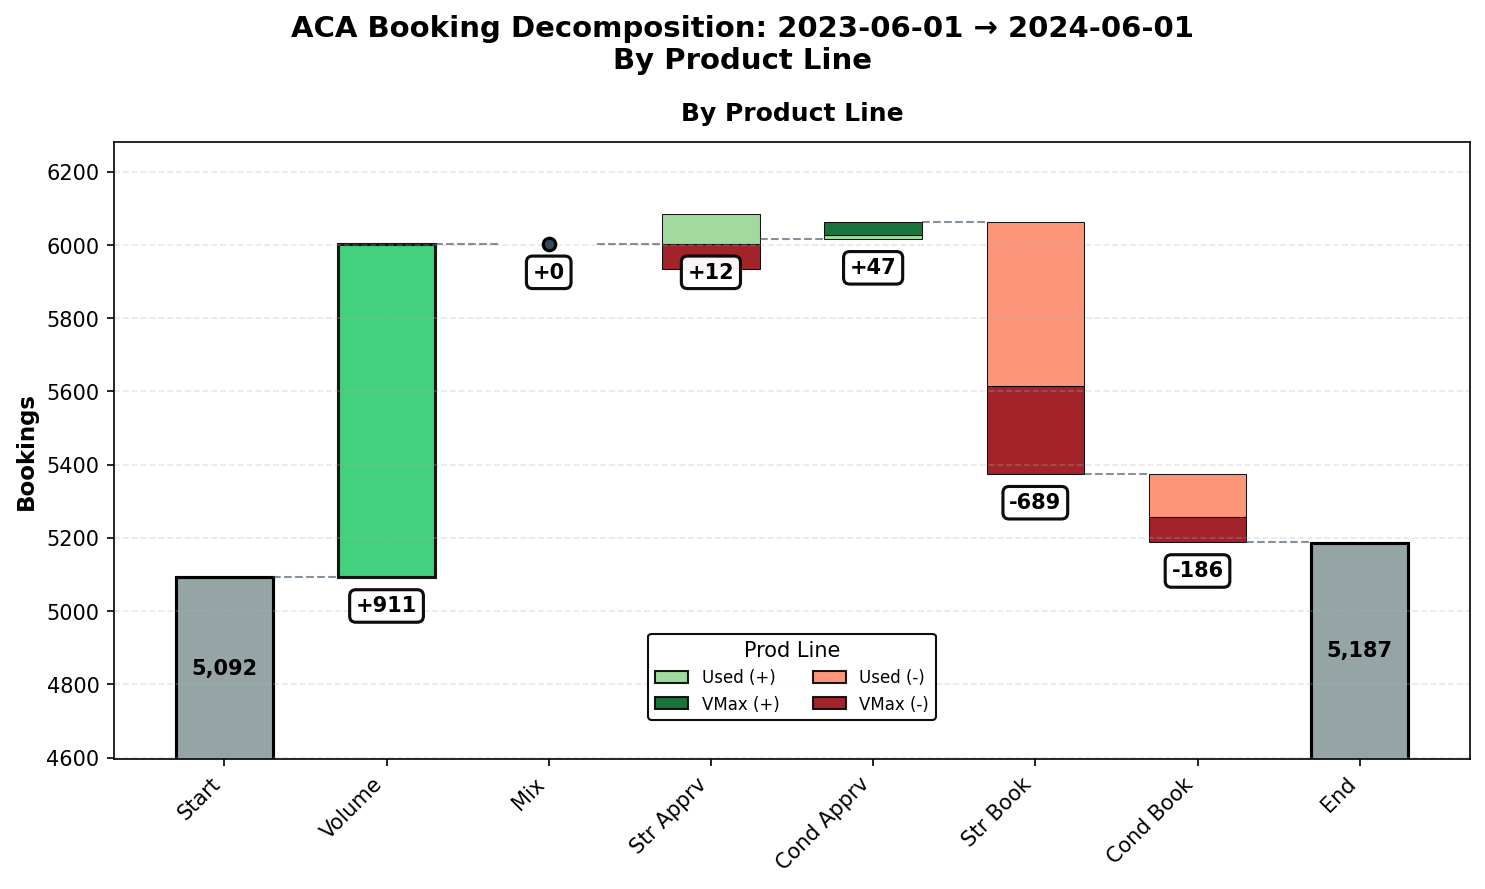

In [5]:
# Extract individual charts from the waterfall grid
grid_charts = extract_individual_charts_from_grid(
    summary=results.summary,
    segment_detail=results.segment_detail,
    lender='ACA'
)

print(f"Extracted {len(grid_charts)} individual charts from the grid:")
print("  [0] Overall Aggregate Waterfall")
print("  [1] By FICO Bands")
print("  [2] By Offer Comp Tier")
print("  [3] By Product Line")
print("\nYou can now:")
print("  - Display them: plt.show() or grid_charts[0].show()")
print("  - Export them: export_chart_list(grid_charts, 'waterfall_grid')")
print("  - Access individually: grid_charts[0], grid_charts[1], etc.")

In [6]:
# Display the individual charts
for i, chart in enumerate(grid_charts):
    plt.figure(chart.number)
    plt.show()

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [7]:
# Export all charts from the grid
# Uncomment to save:
# paths = export_chart_list(grid_charts, 'waterfall_grid', output_dir='../output/charts')
# print(f"\nExported {len(paths)} charts")

## 5. Example: Extract Individual Charts from Dimension Drilldown

This splits the drilldown into 7 separate effect charts.

Extracted 7 individual effect charts:
  [0] Total Net Impact
  [1] Volume Effect
  [2] Mix Effect
  [3] Straight Approval Effect
  [4] Conditional Approval Effect
  [5] Straight Booking Effect
  [6] Conditional Booking Effect


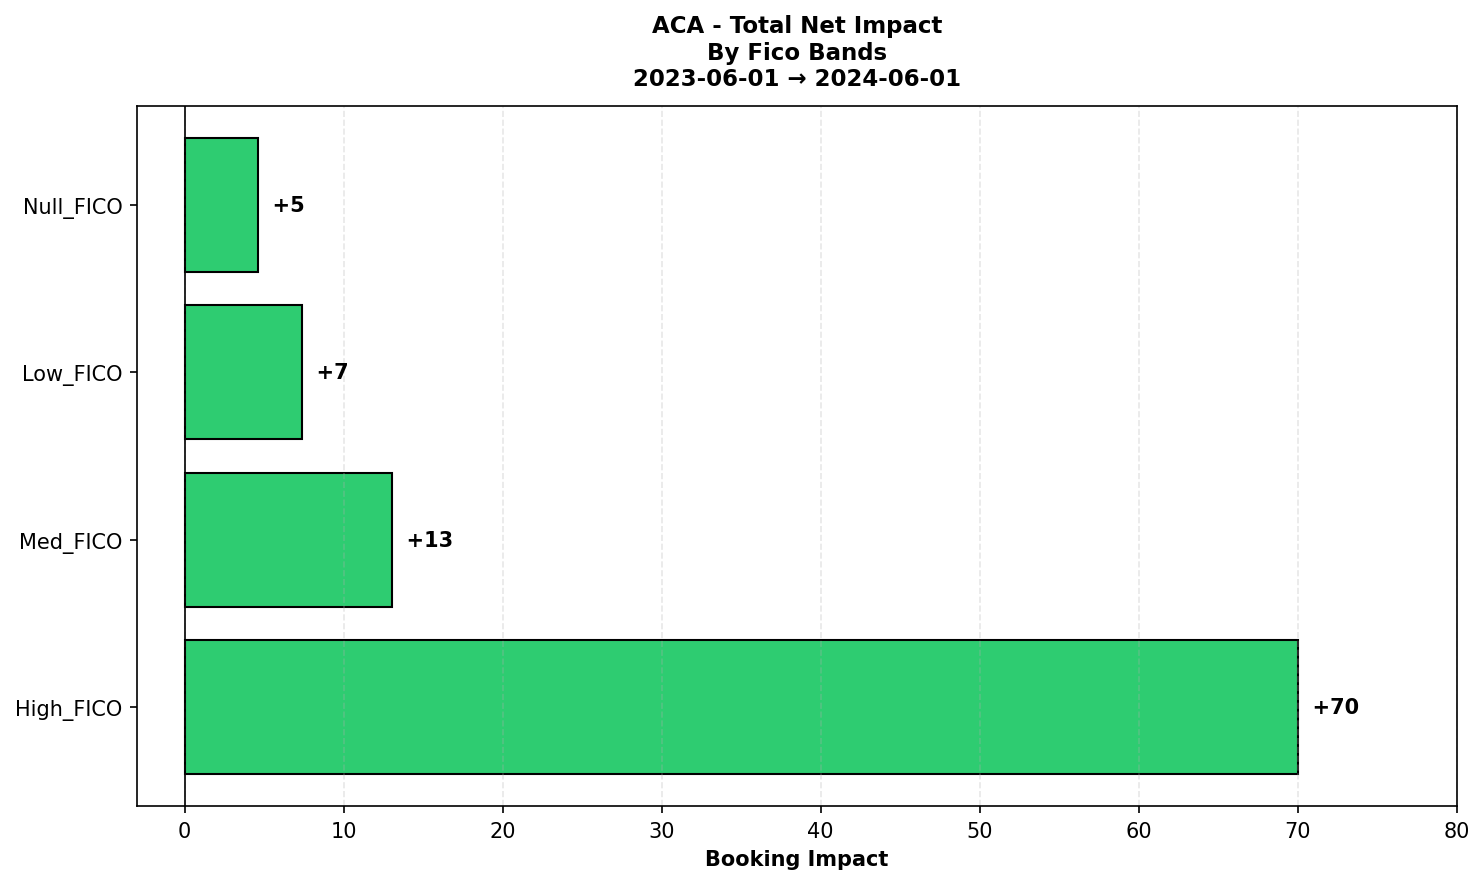

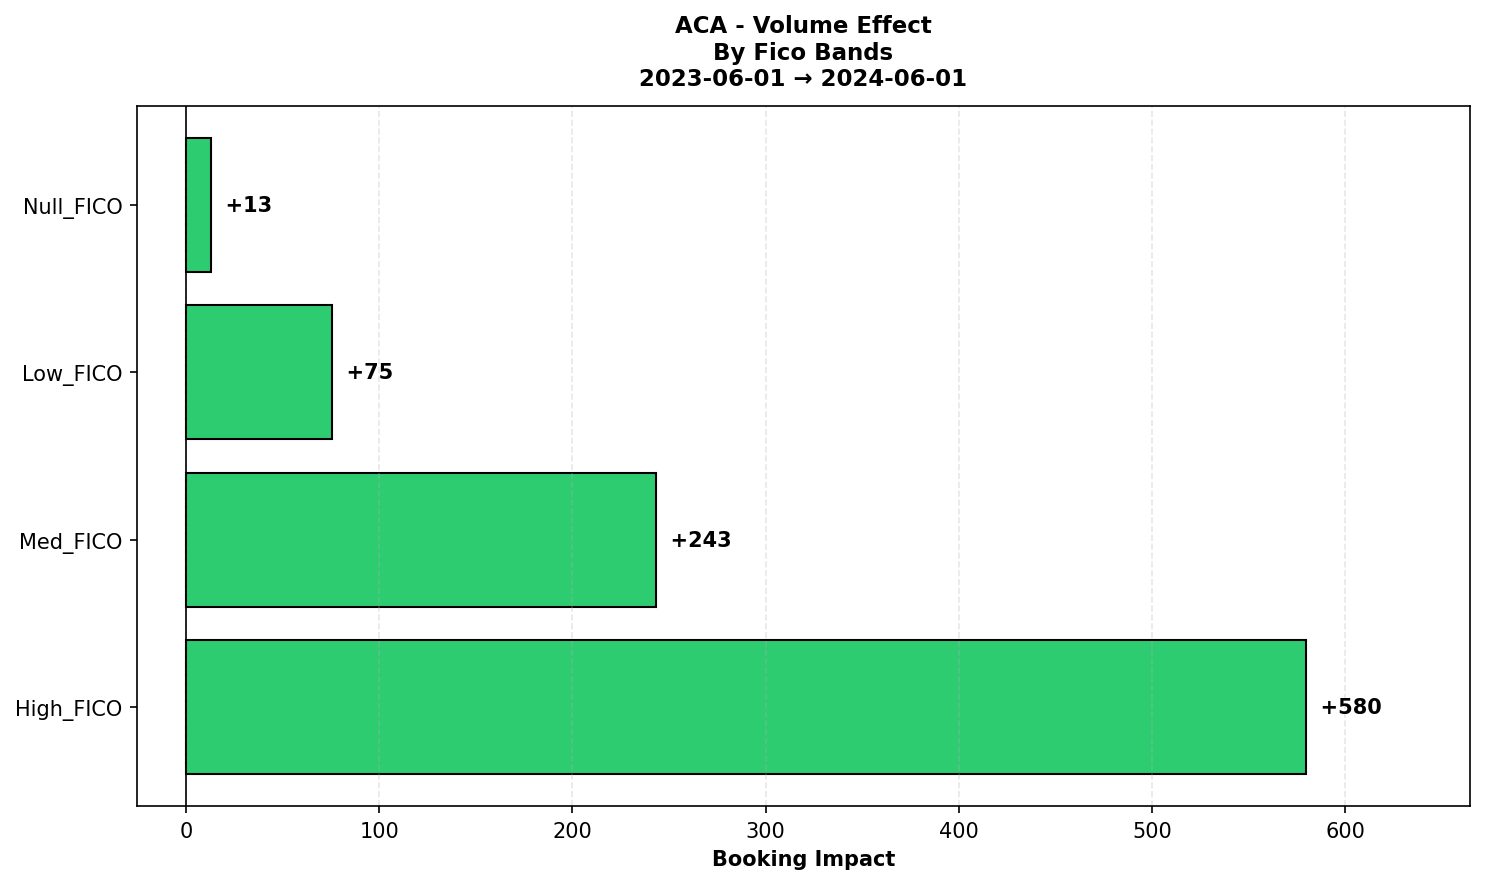

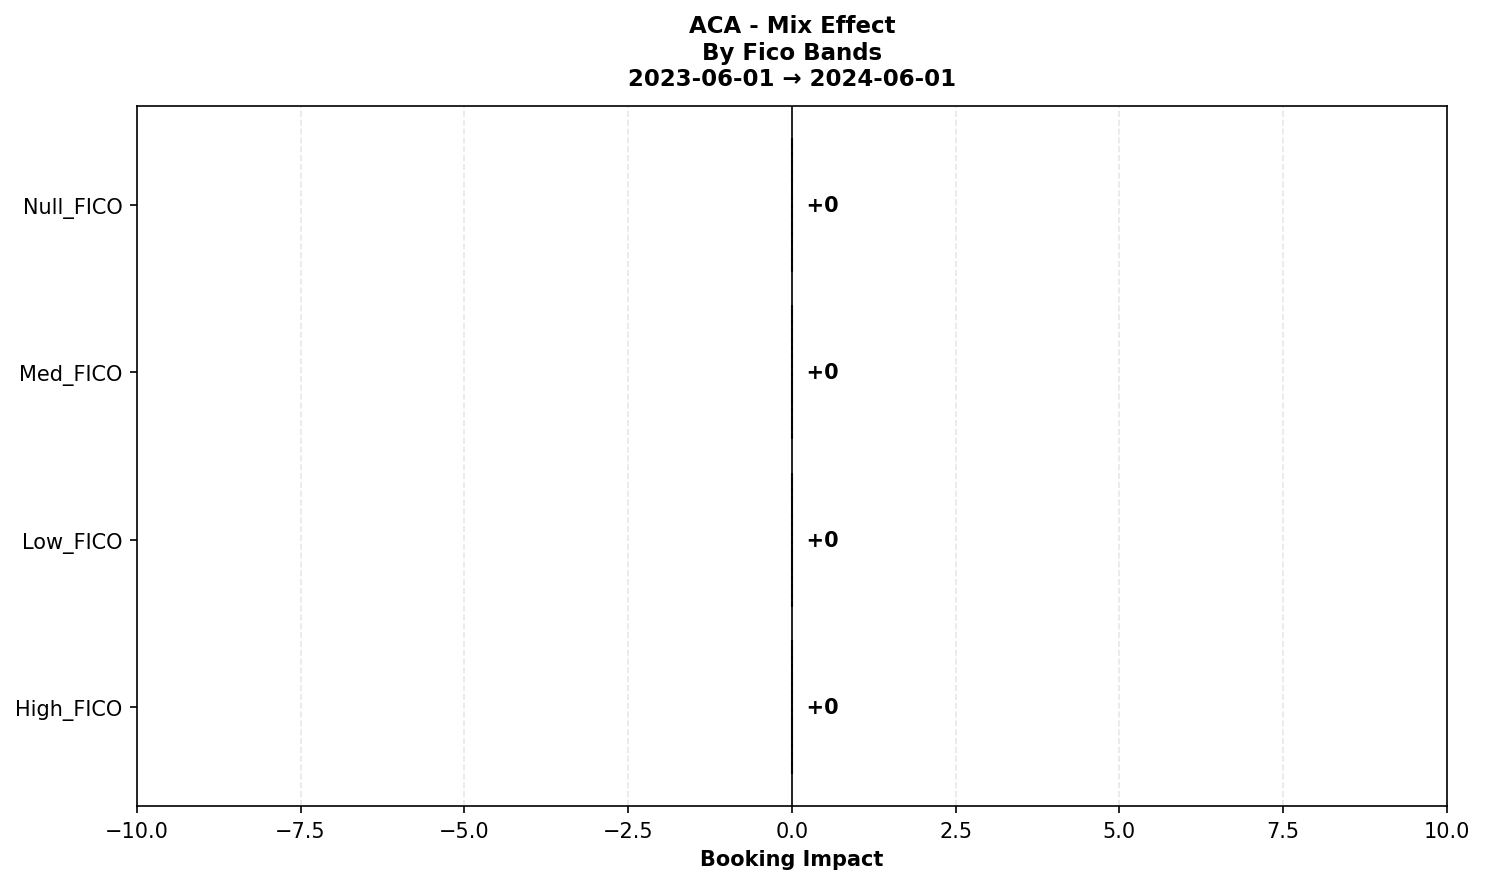

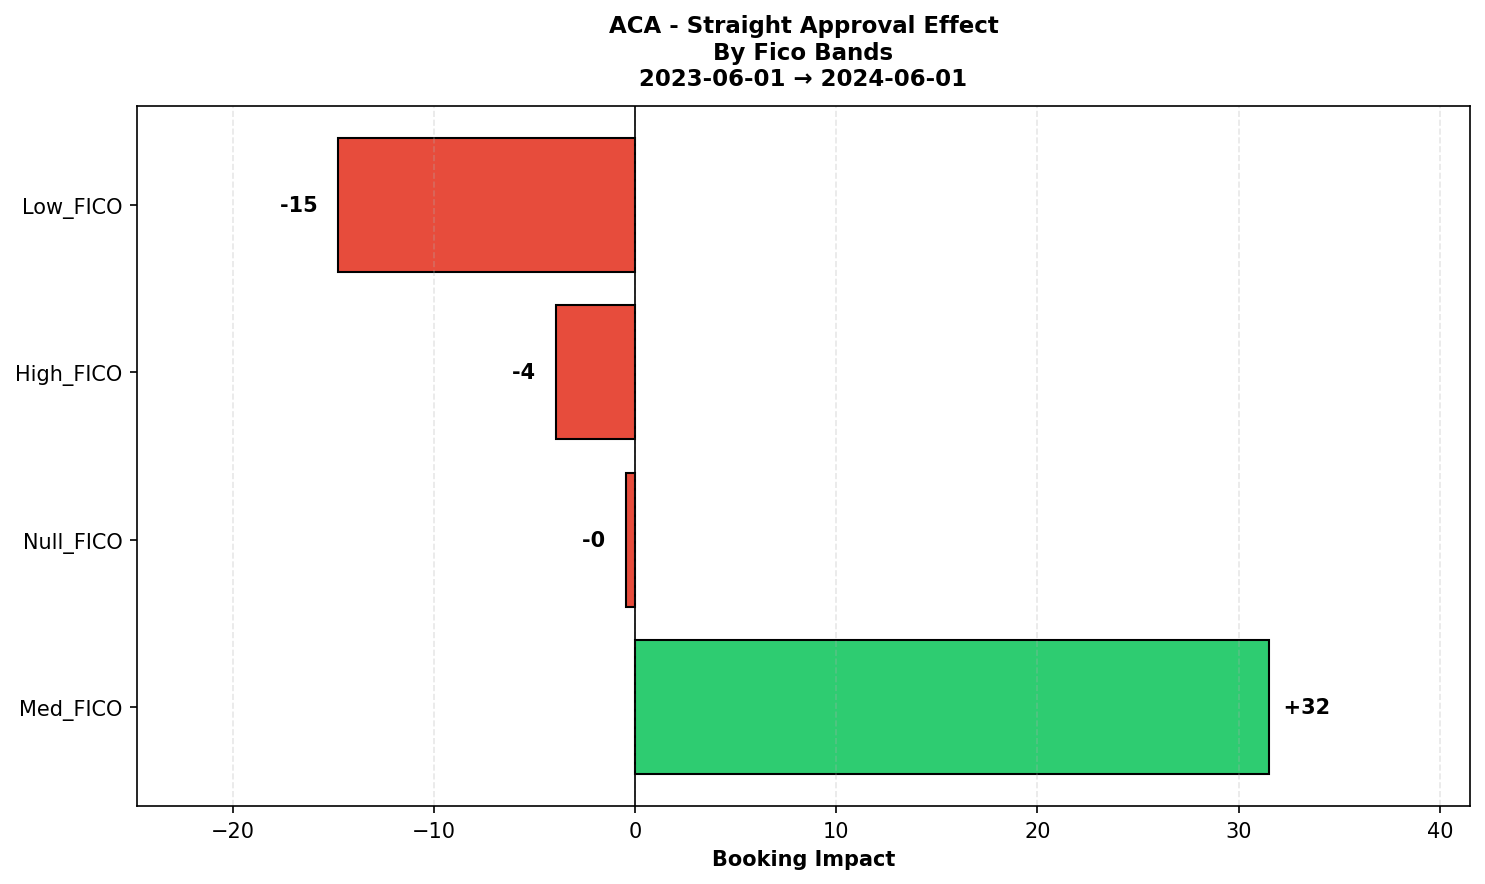

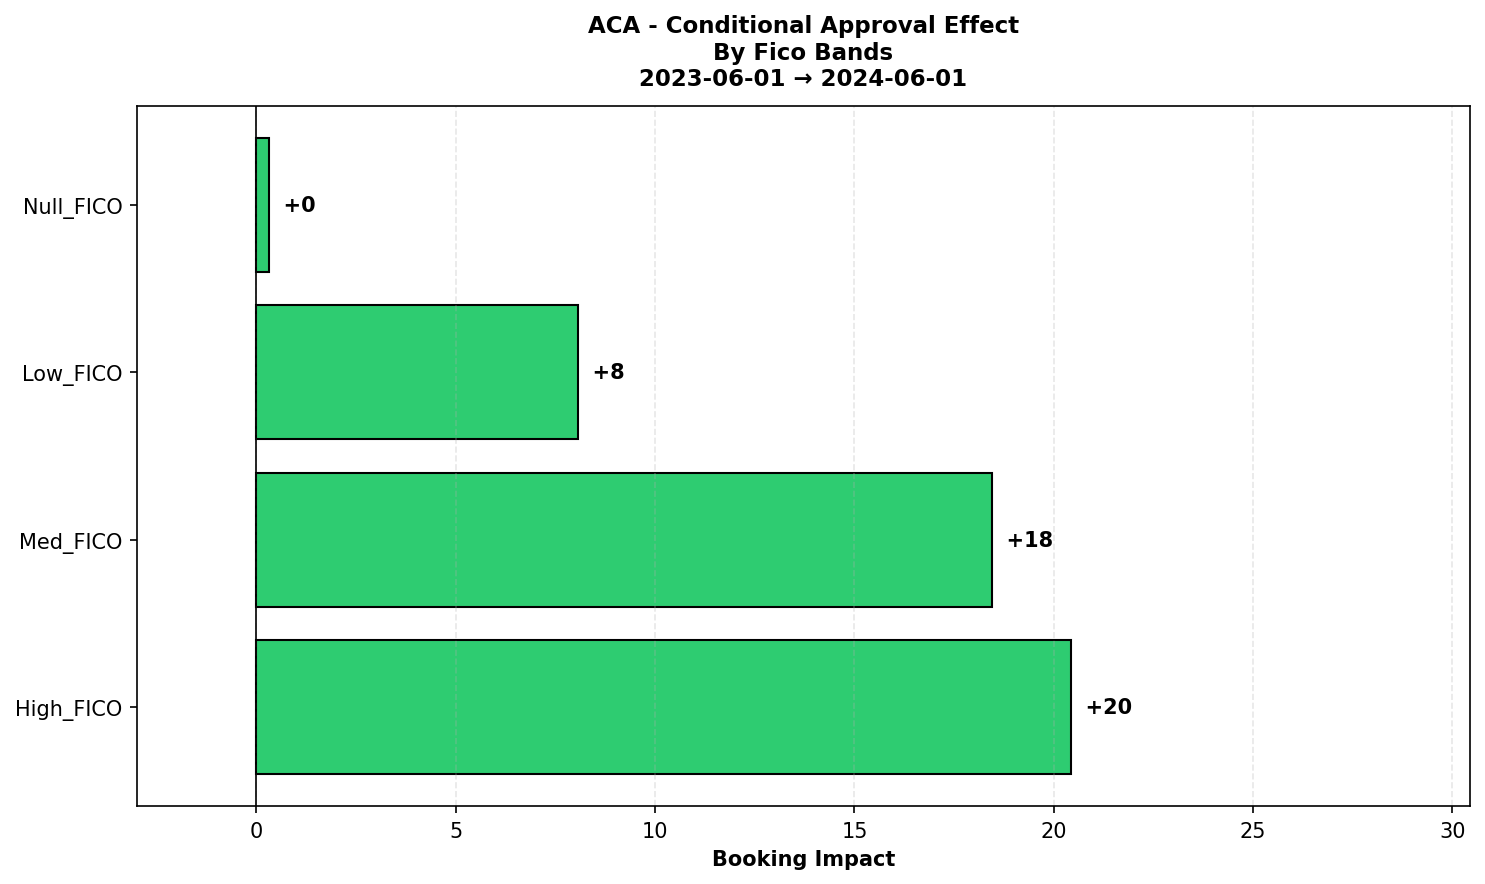

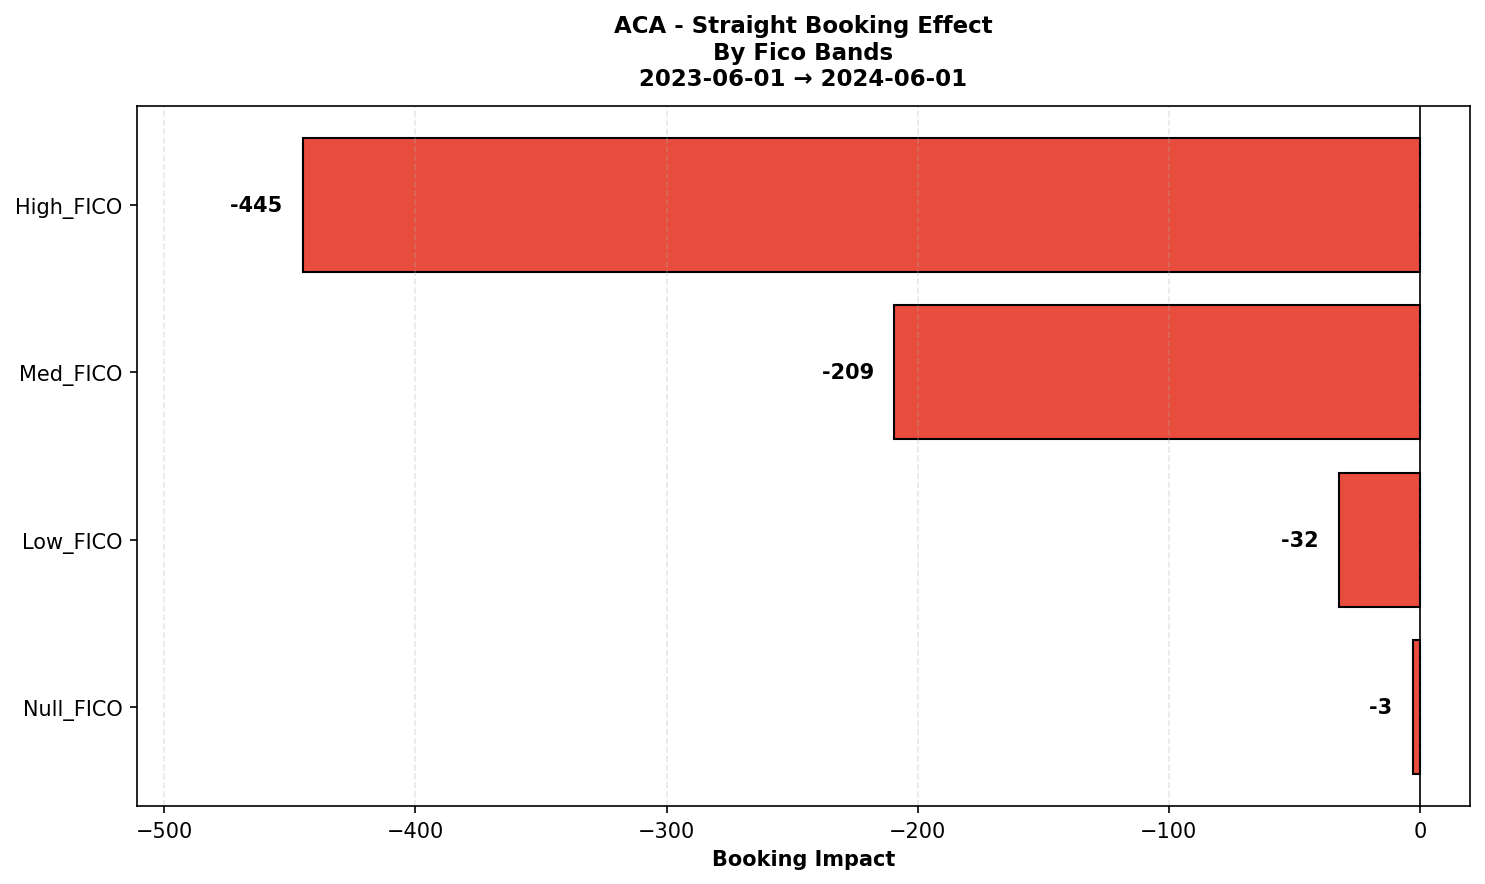

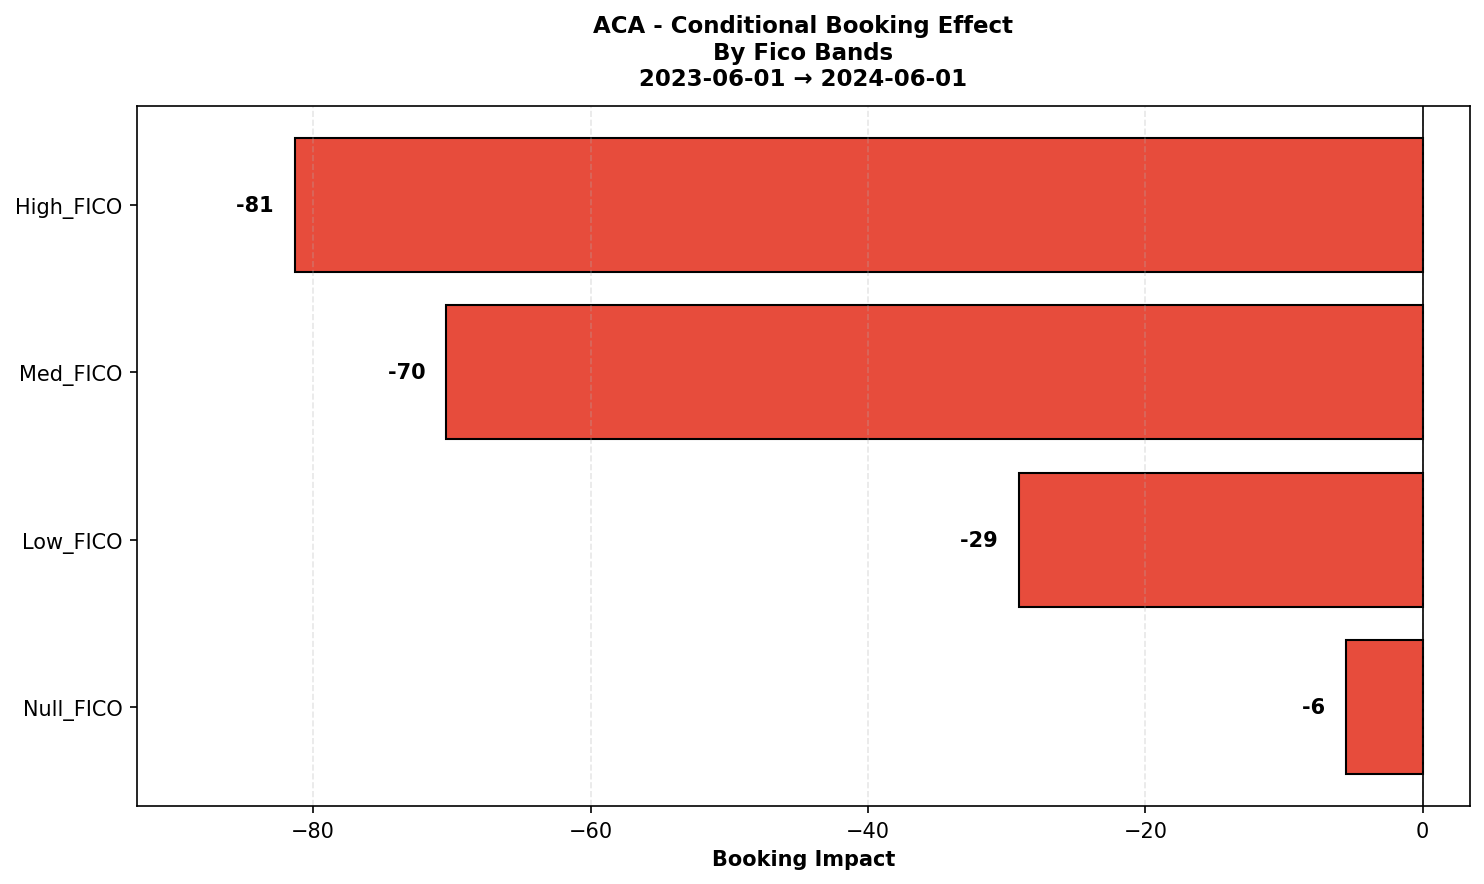

In [8]:
# Extract individual charts for FICO bands drilldown
fico_drilldown_charts = extract_individual_drilldown_charts(
    segment_detail=results.segment_detail,
    dimension='fico_bands',
    lender='ACA'
)

print(f"Extracted {len(fico_drilldown_charts)} individual effect charts:")
print("  [0] Total Net Impact")
print("  [1] Volume Effect")
print("  [2] Mix Effect")
print("  [3] Straight Approval Effect")
print("  [4] Conditional Approval Effect")
print("  [5] Straight Booking Effect")
print("  [6] Conditional Booking Effect")

In [9]:
# Display individual drilldown charts
for i, chart in enumerate(fico_drilldown_charts):
    plt.figure(chart.number)
    plt.show()

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [10]:
# Export drilldown charts
# Uncomment to save:
# paths = export_chart_list(fico_drilldown_charts, 'fico_drilldown', output_dir='../output/charts')
# print(f"\nExported {len(paths)} drilldown charts")

## 6. Example: Extract Charts for All Dimensions

Generate individual charts for all three dimensions.

Extracted 7 charts for fico_bands


Extracted 7 charts for offer_comp_tier
Extracted 7 charts for prod_line

Total charts extracted: 21

Access charts via:
  all_dimension_charts['fico_bands'][0]  # First FICO effect chart
  all_dimension_charts['offer_comp_tier'][3]  # Comp tier straight approval
  all_dimension_charts['prod_line'][6]  # Product line cond booking


/tmp/ipykernel_653881/3095661717.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


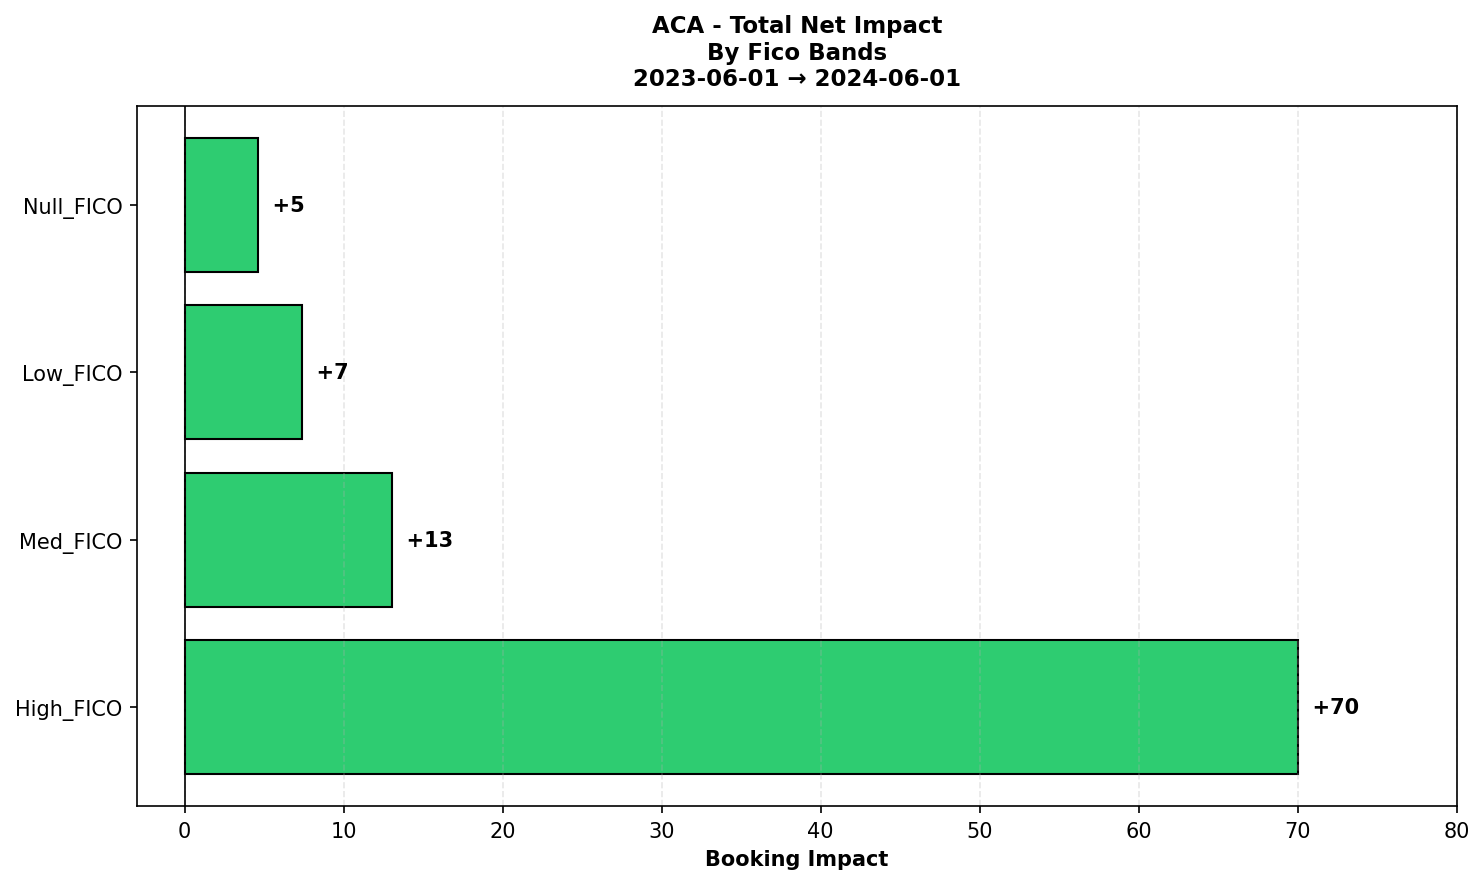

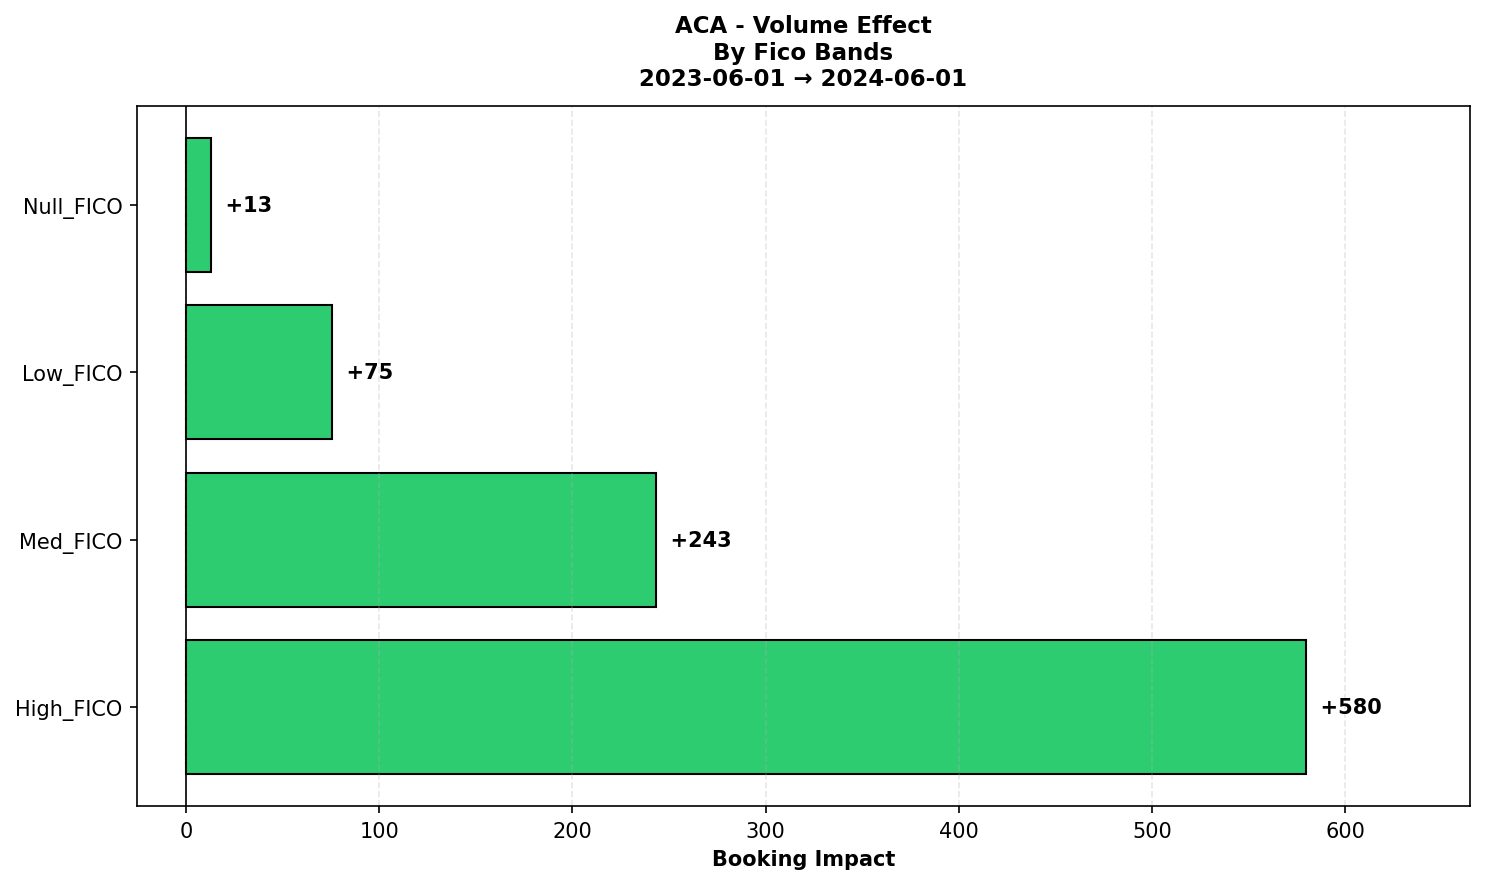

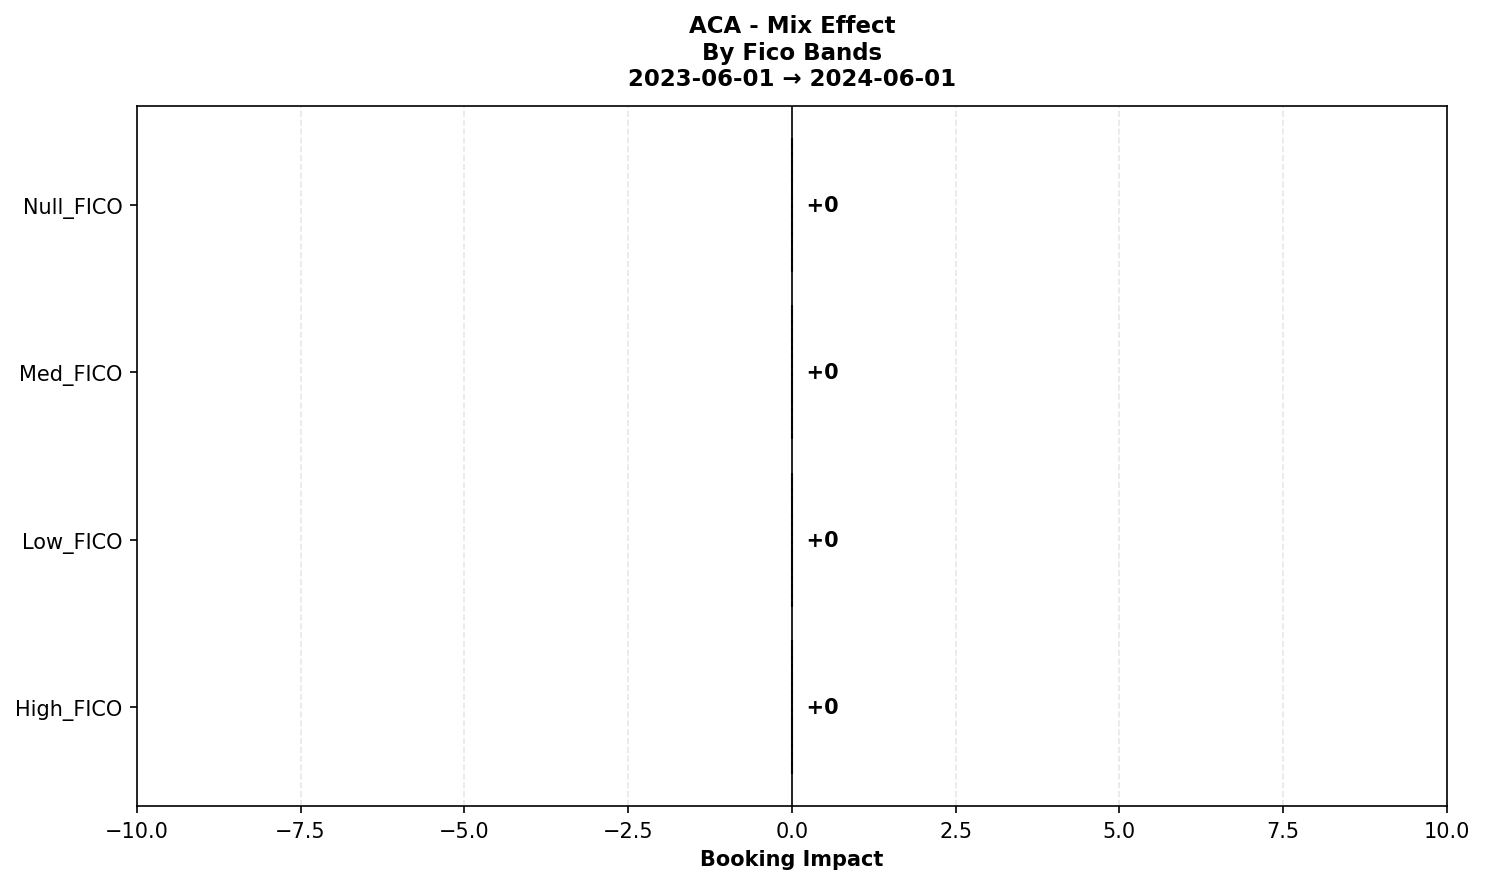

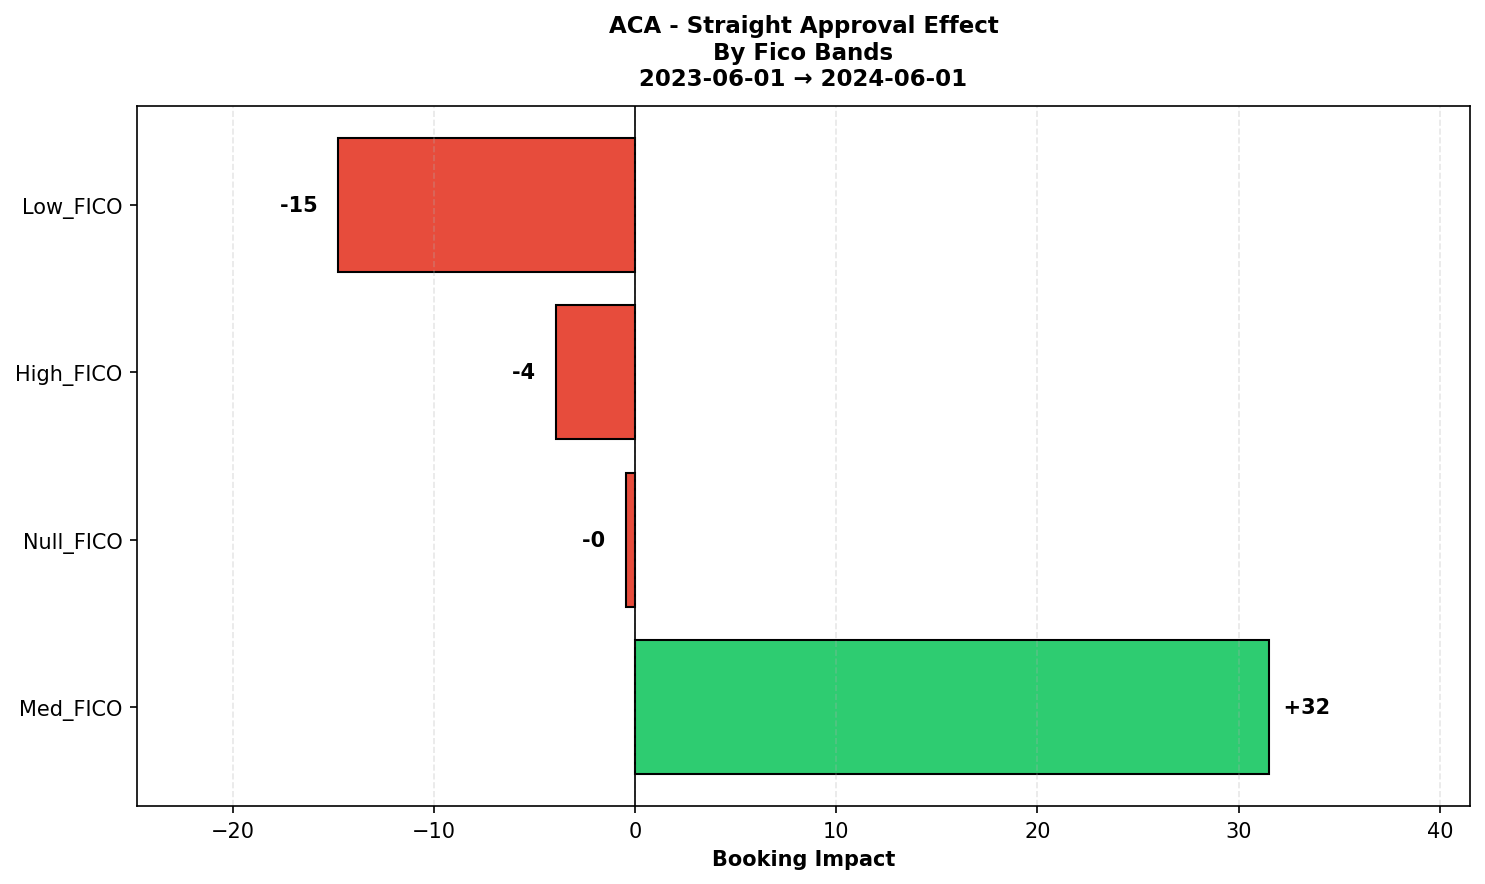

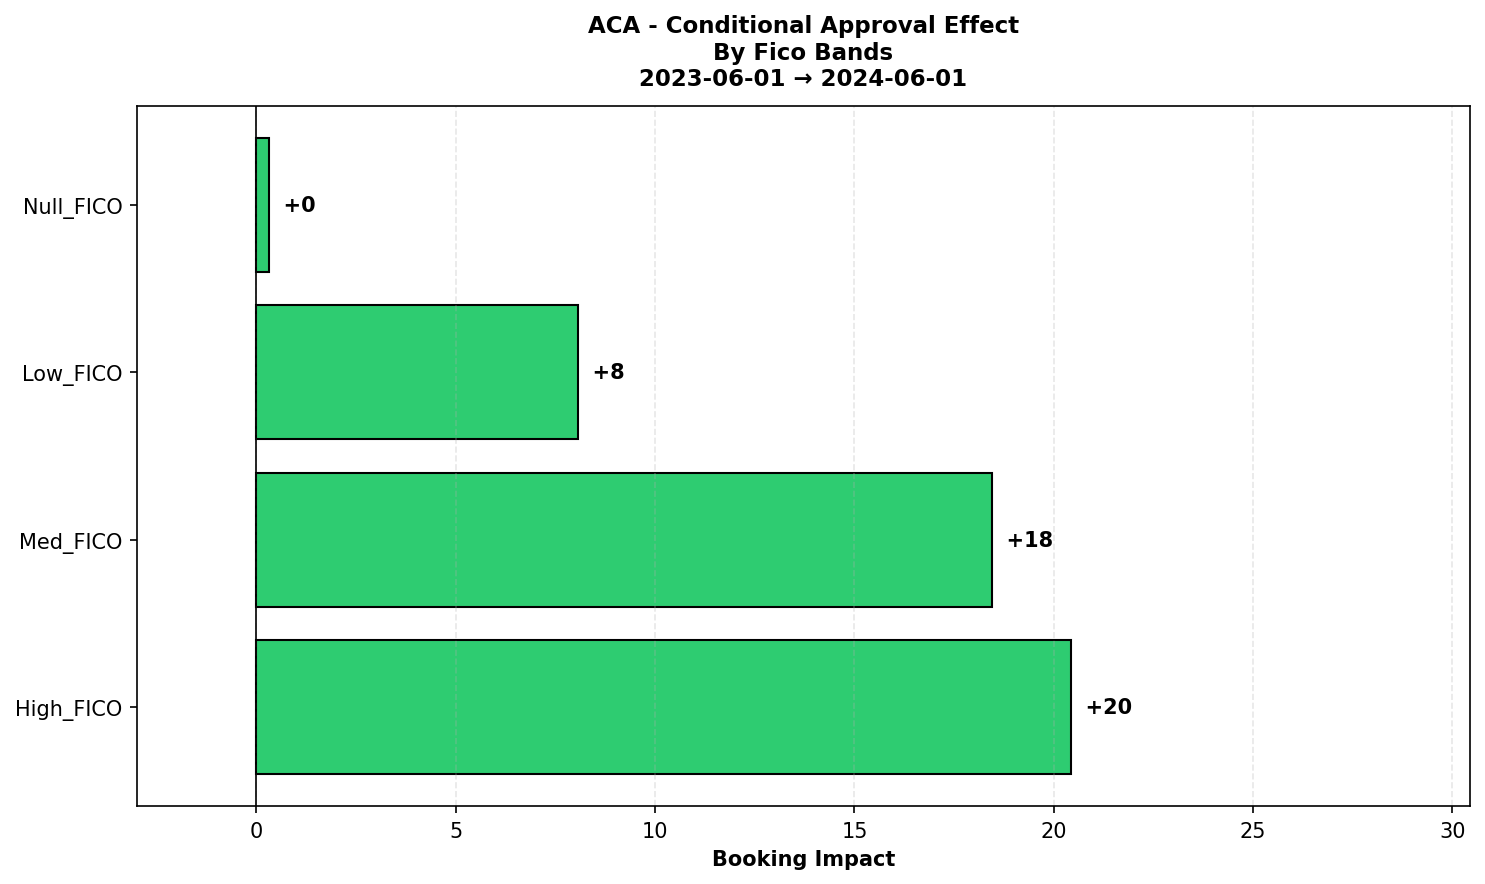

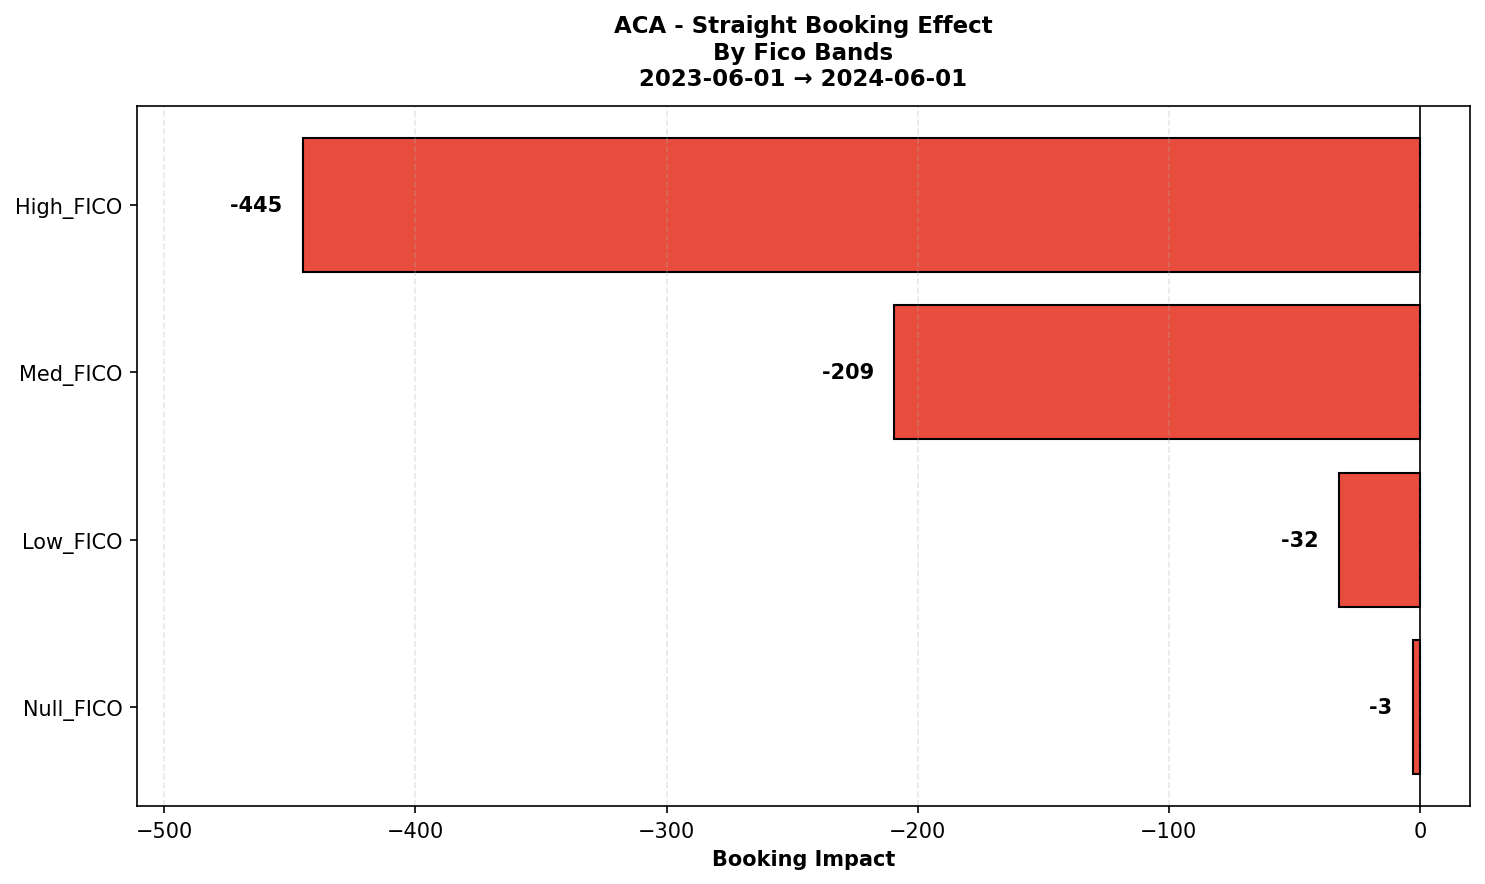

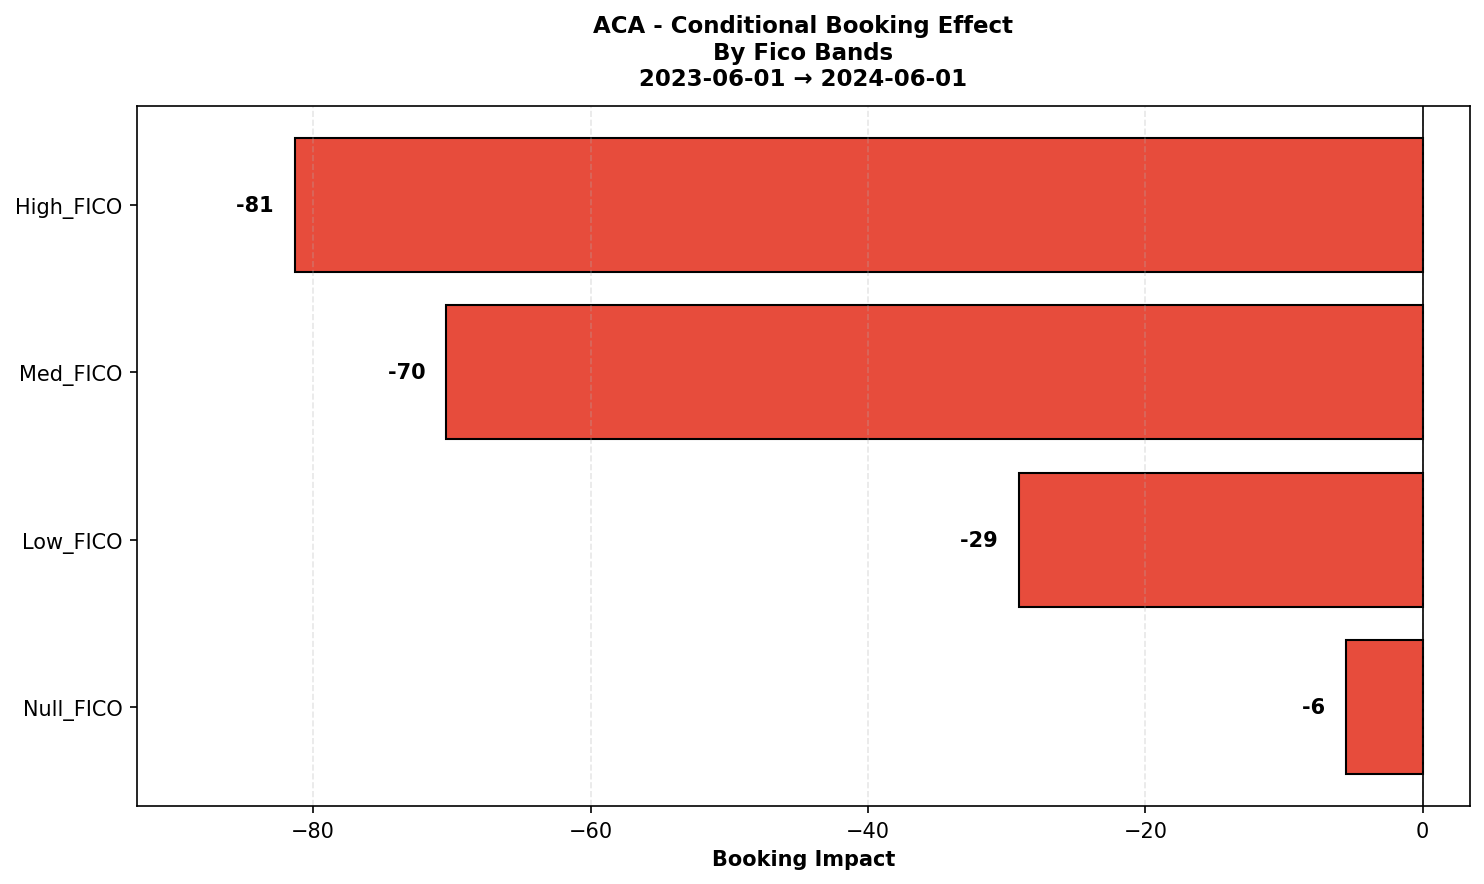

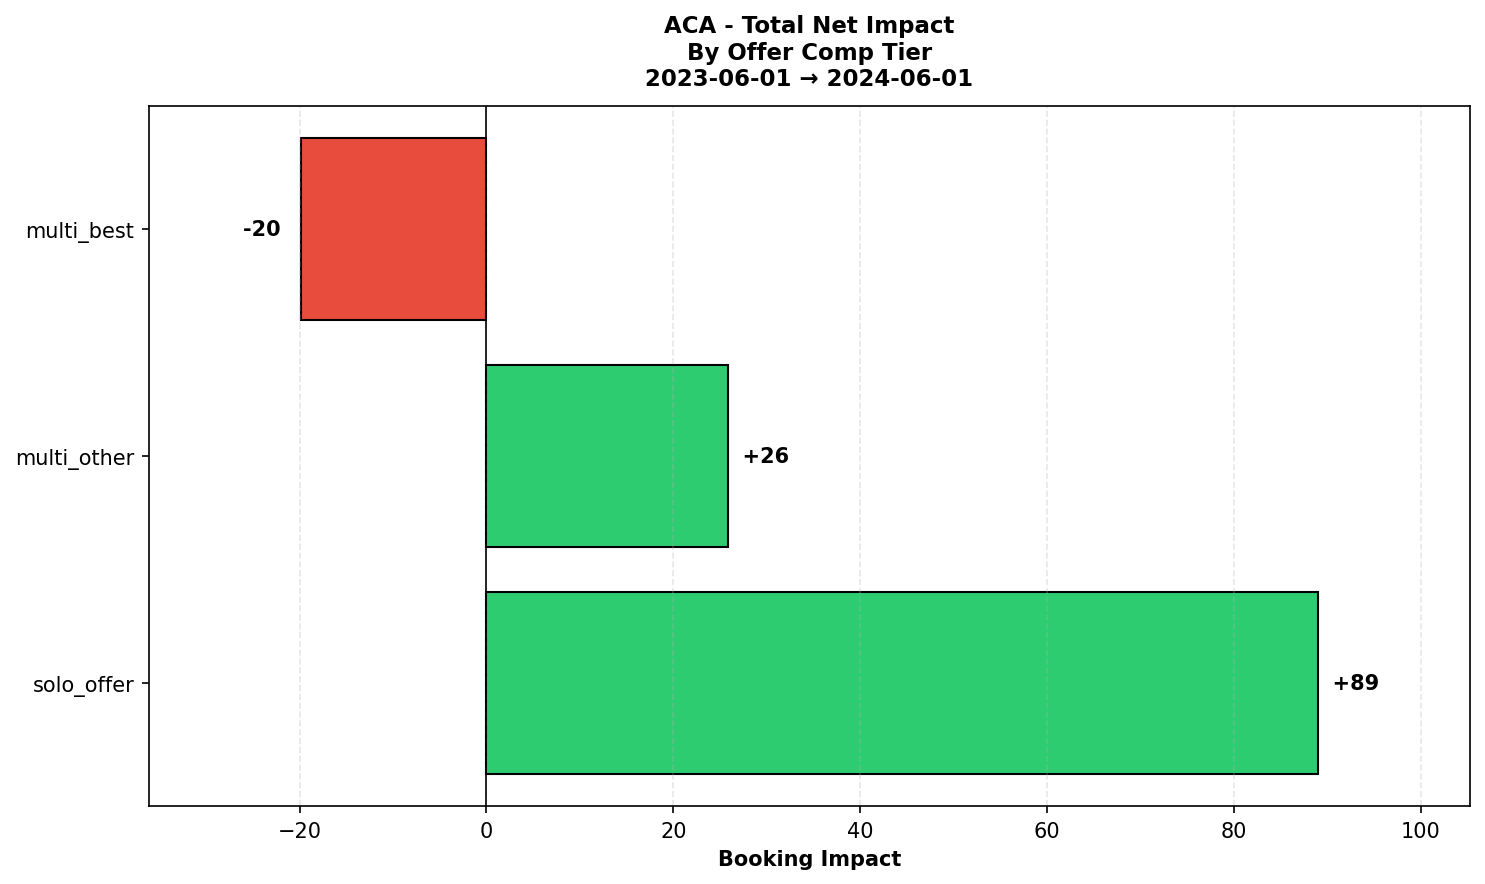

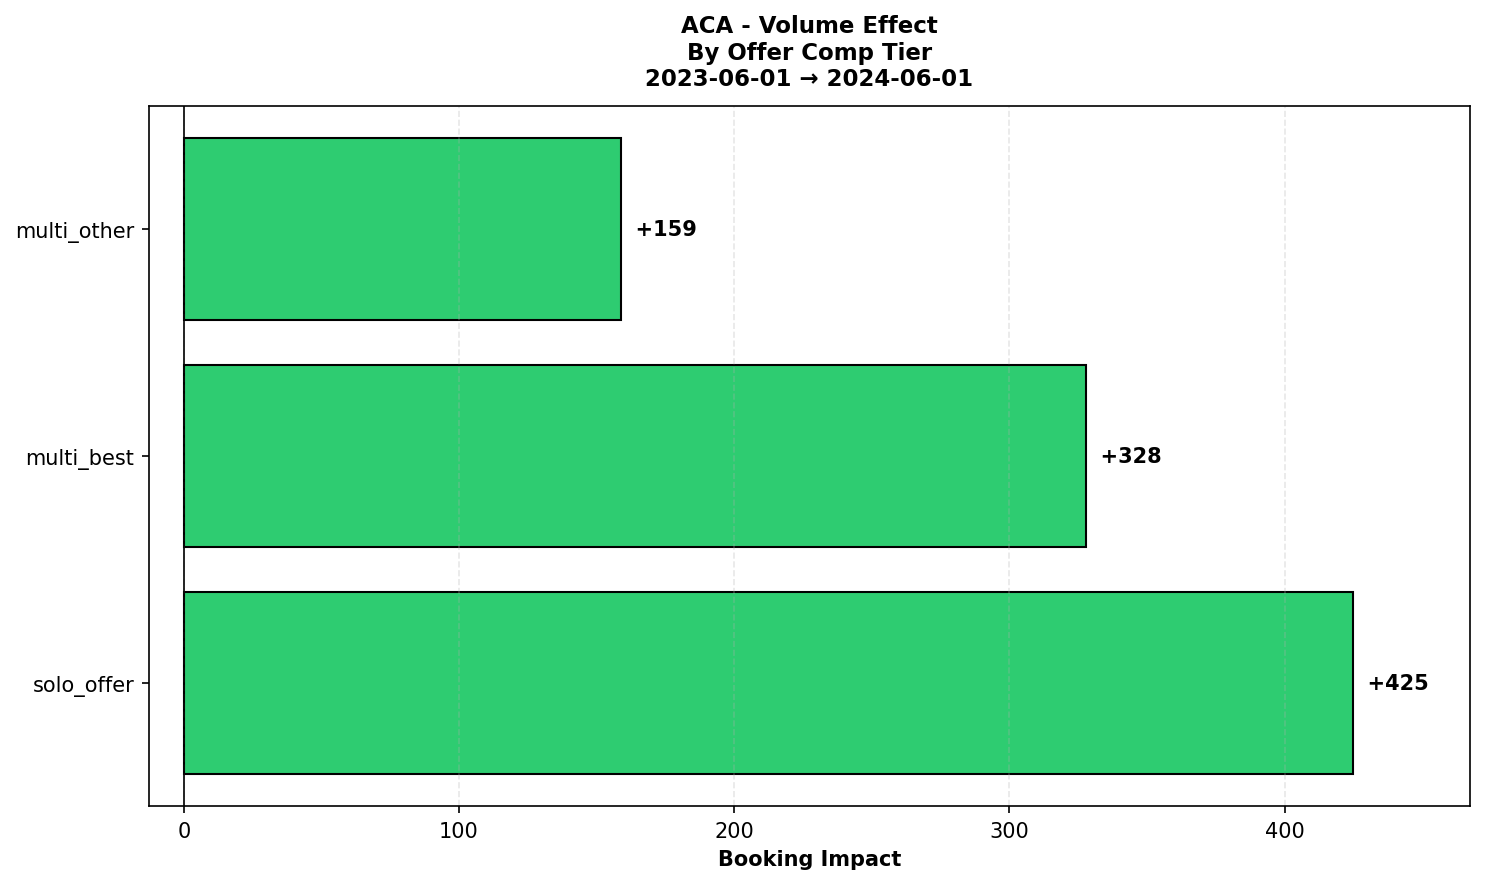

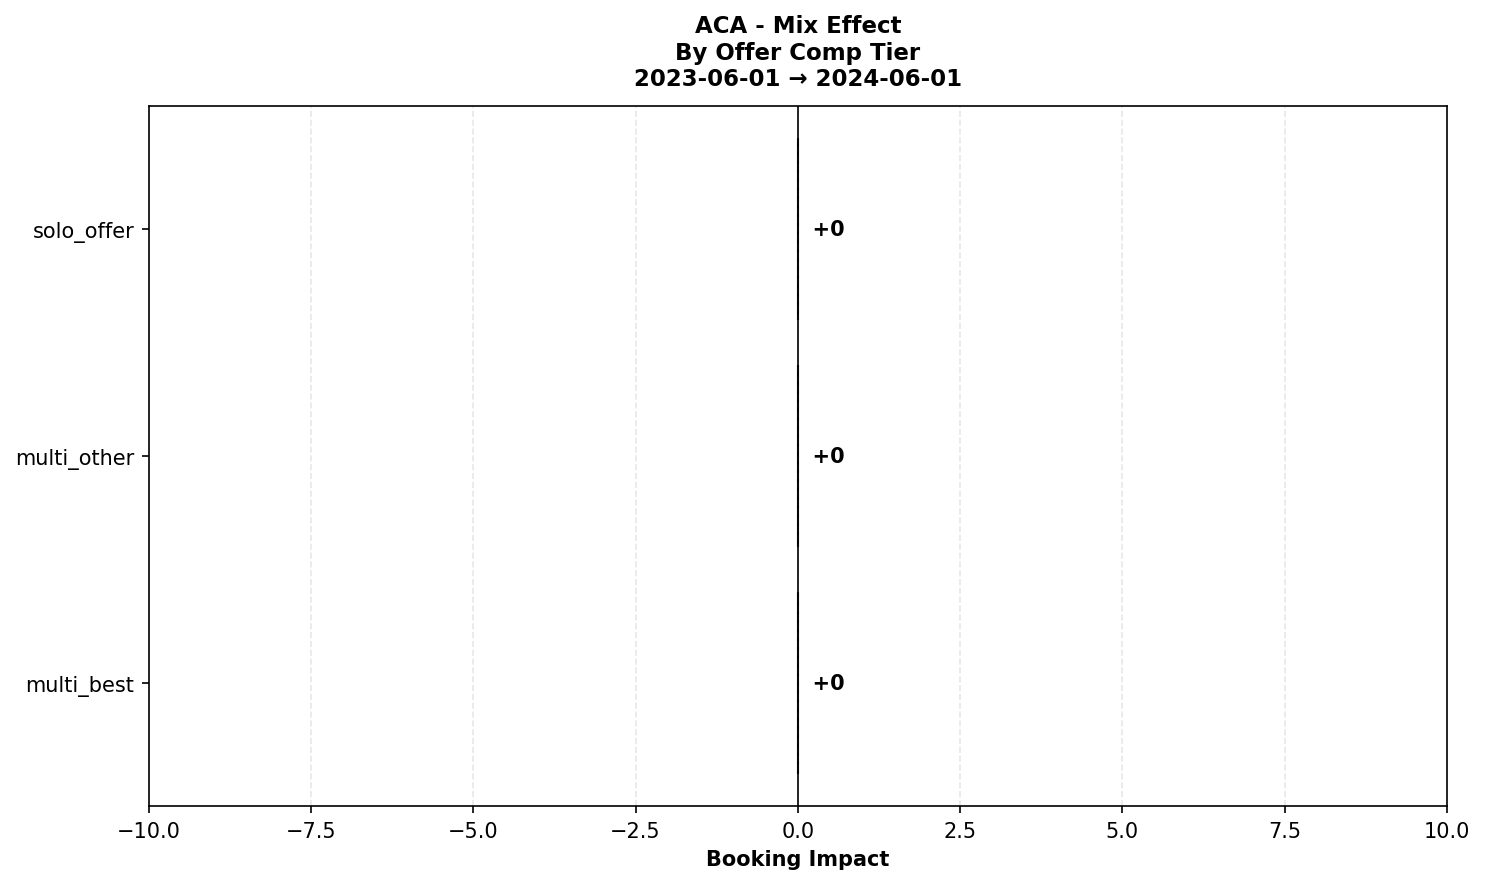

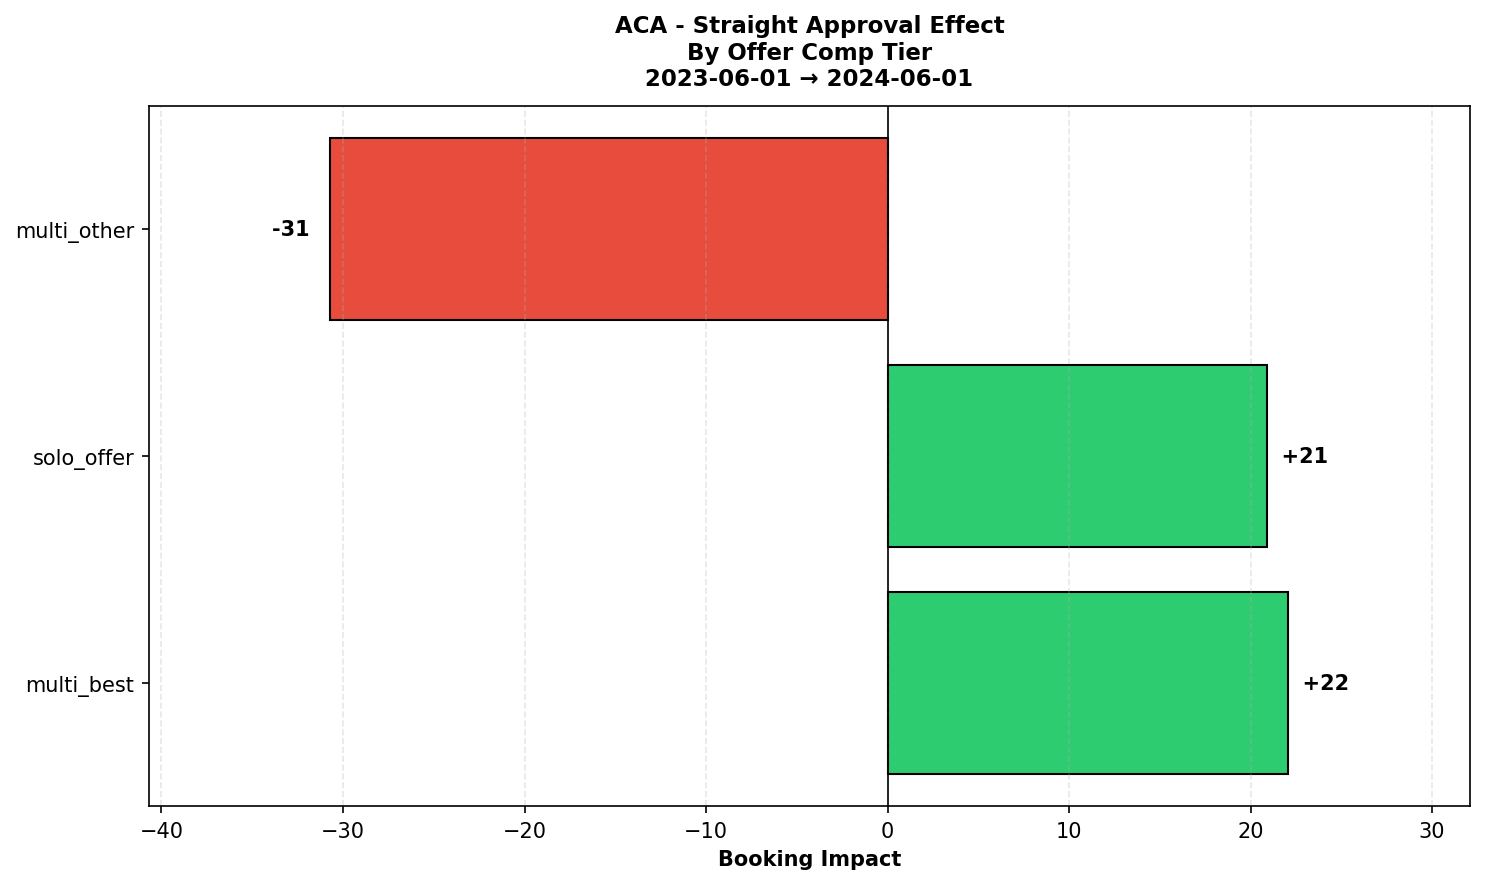

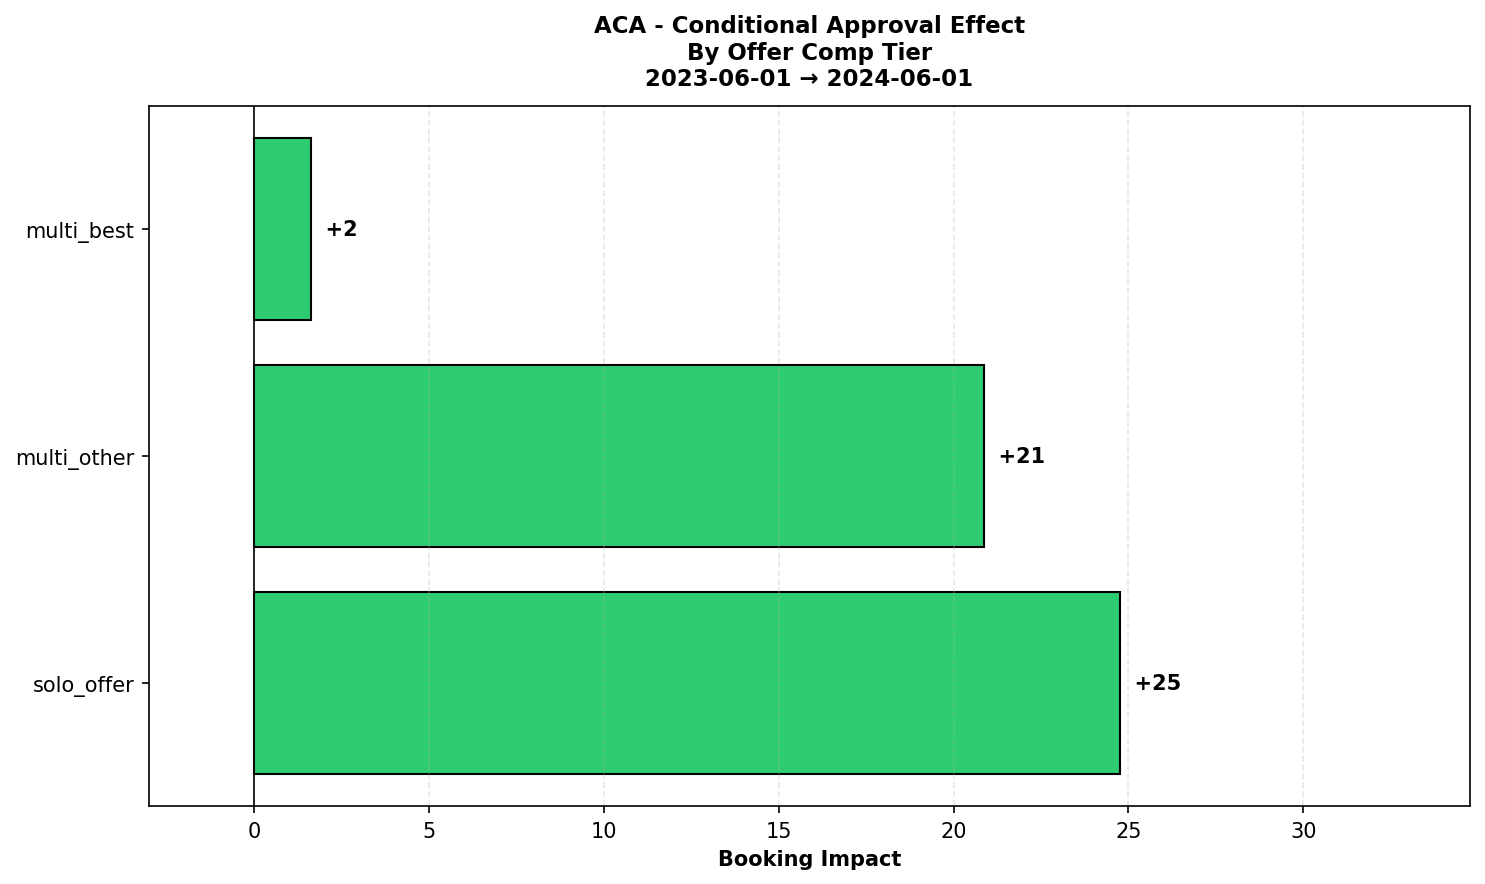

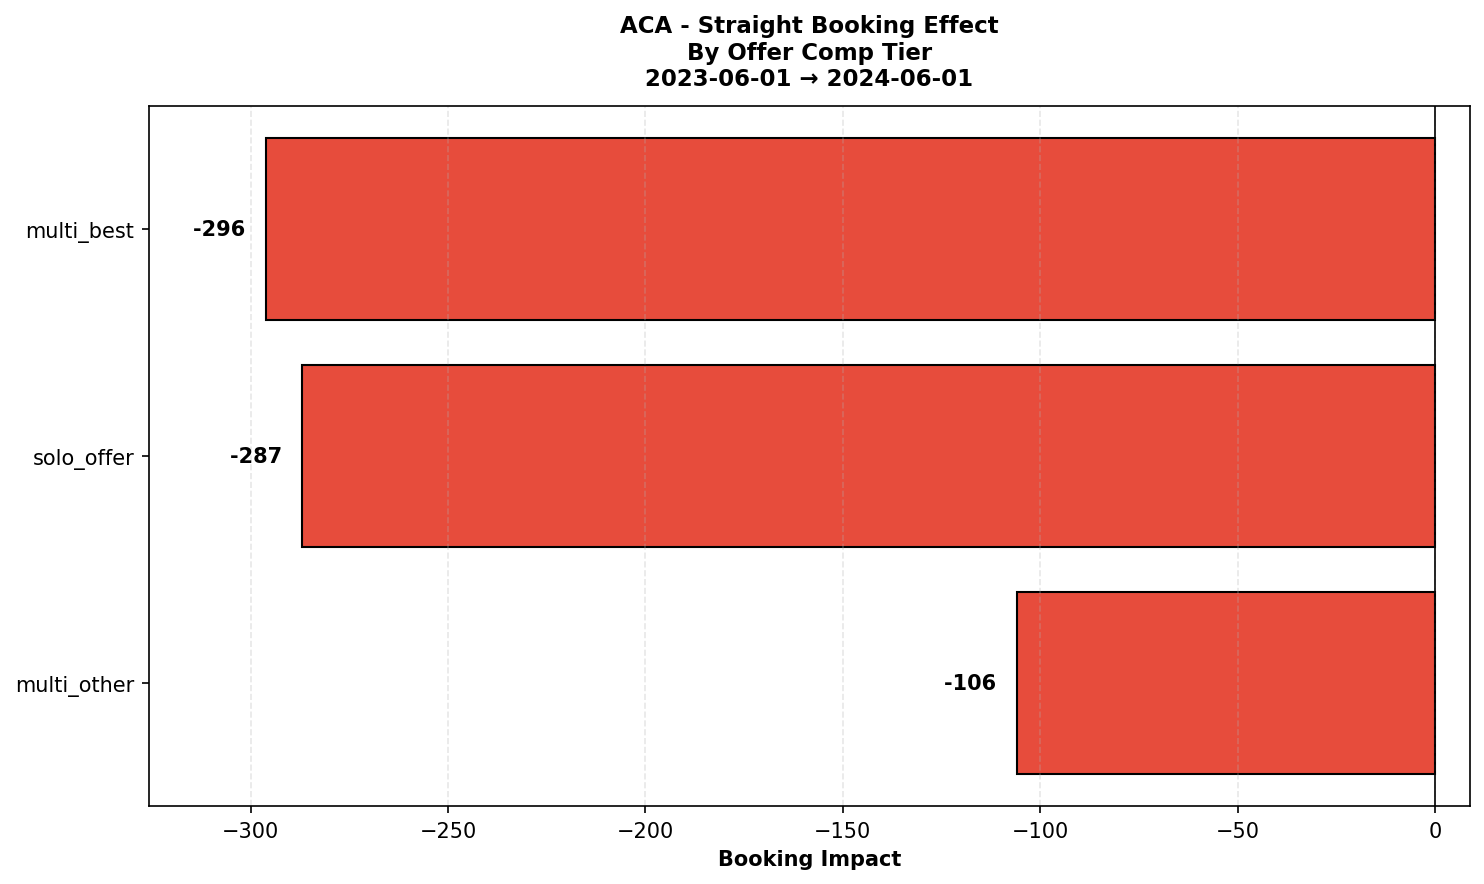

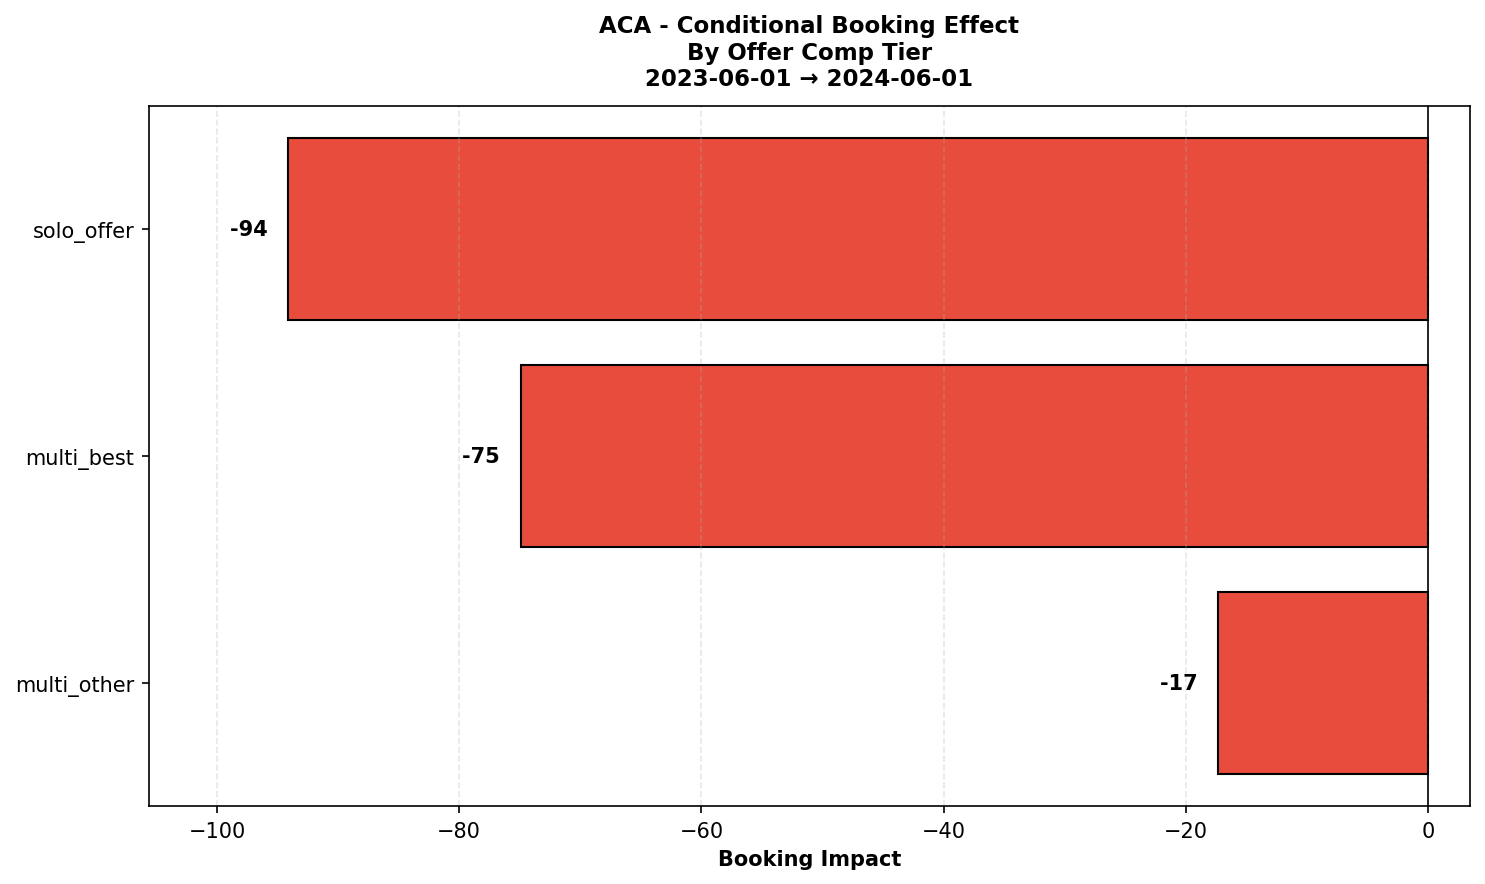

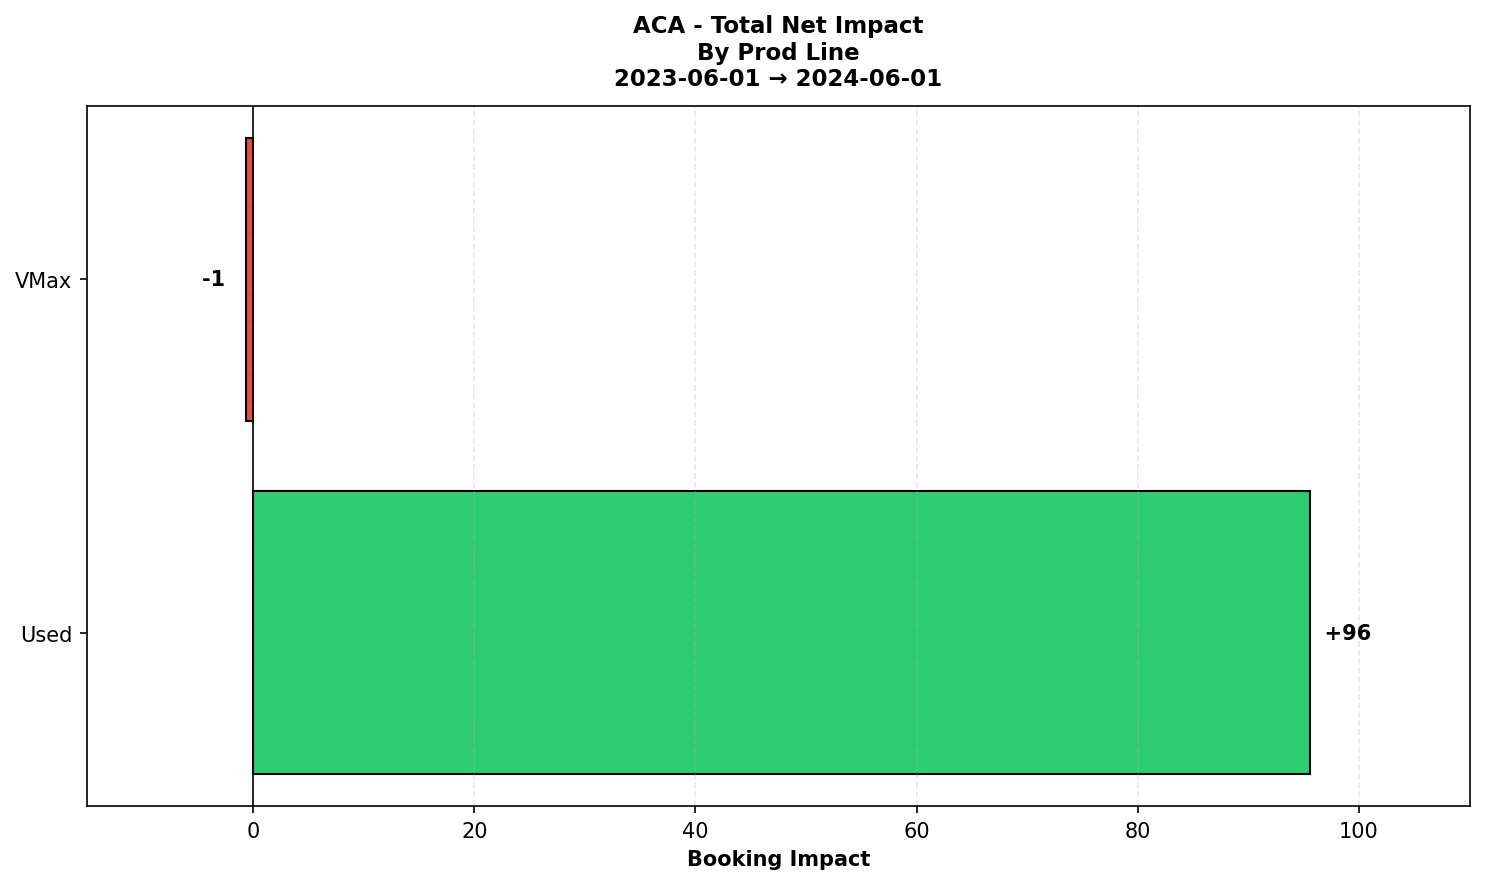

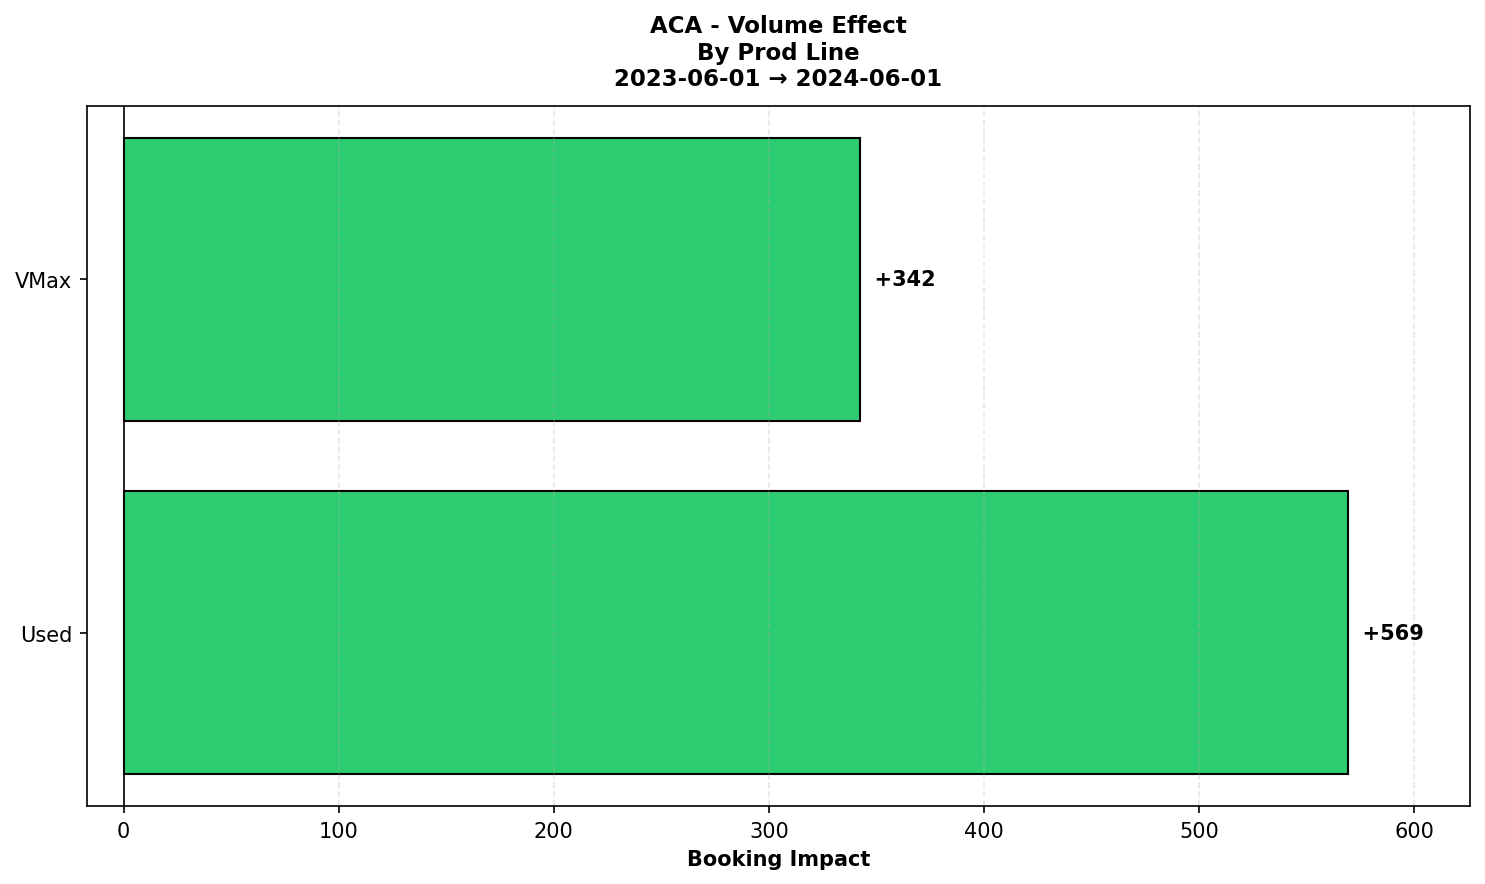

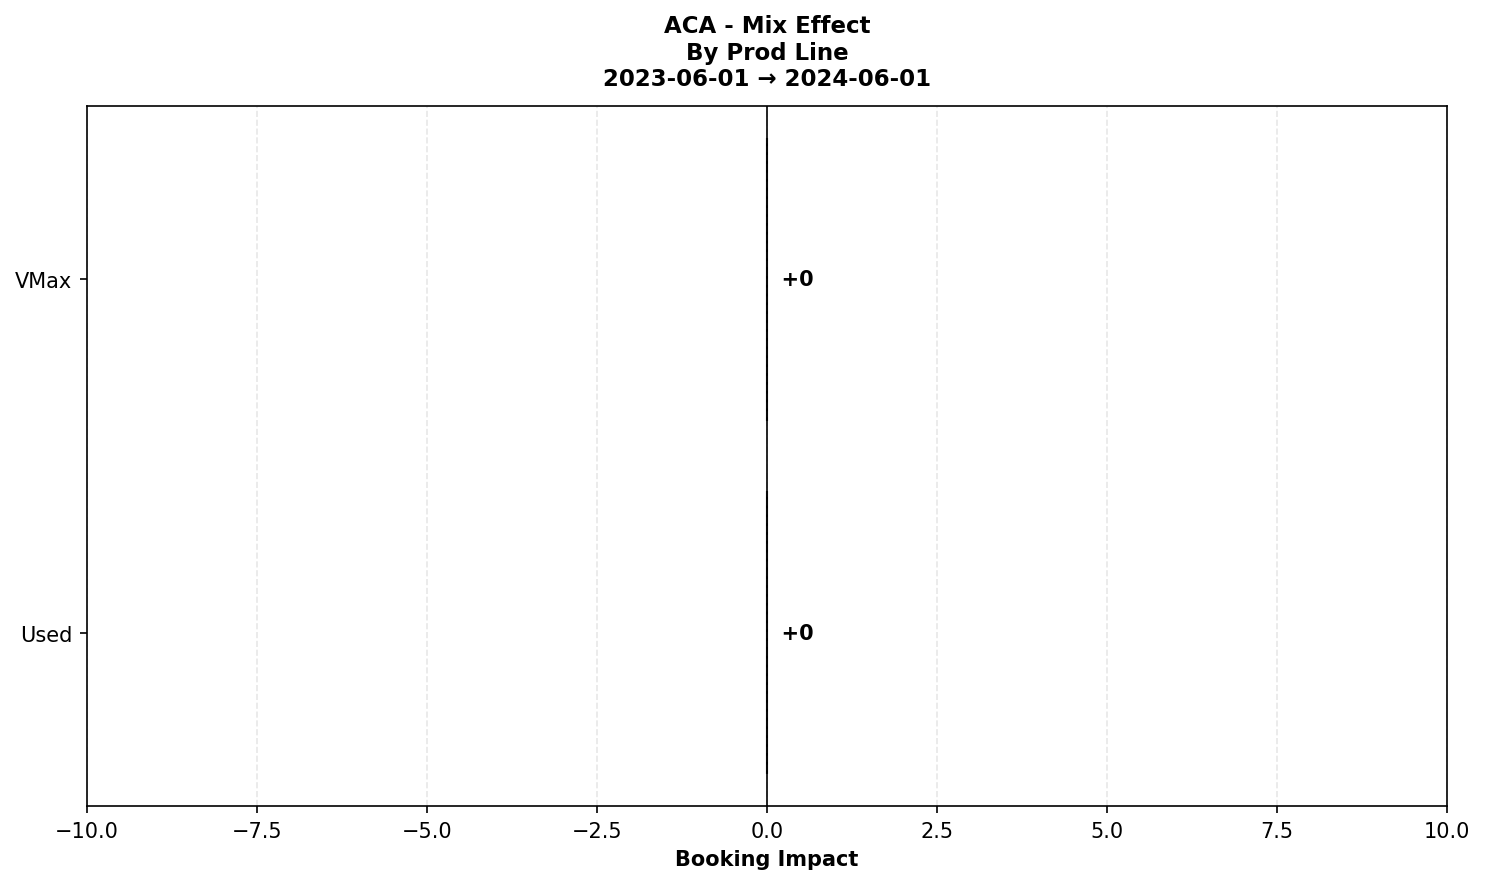

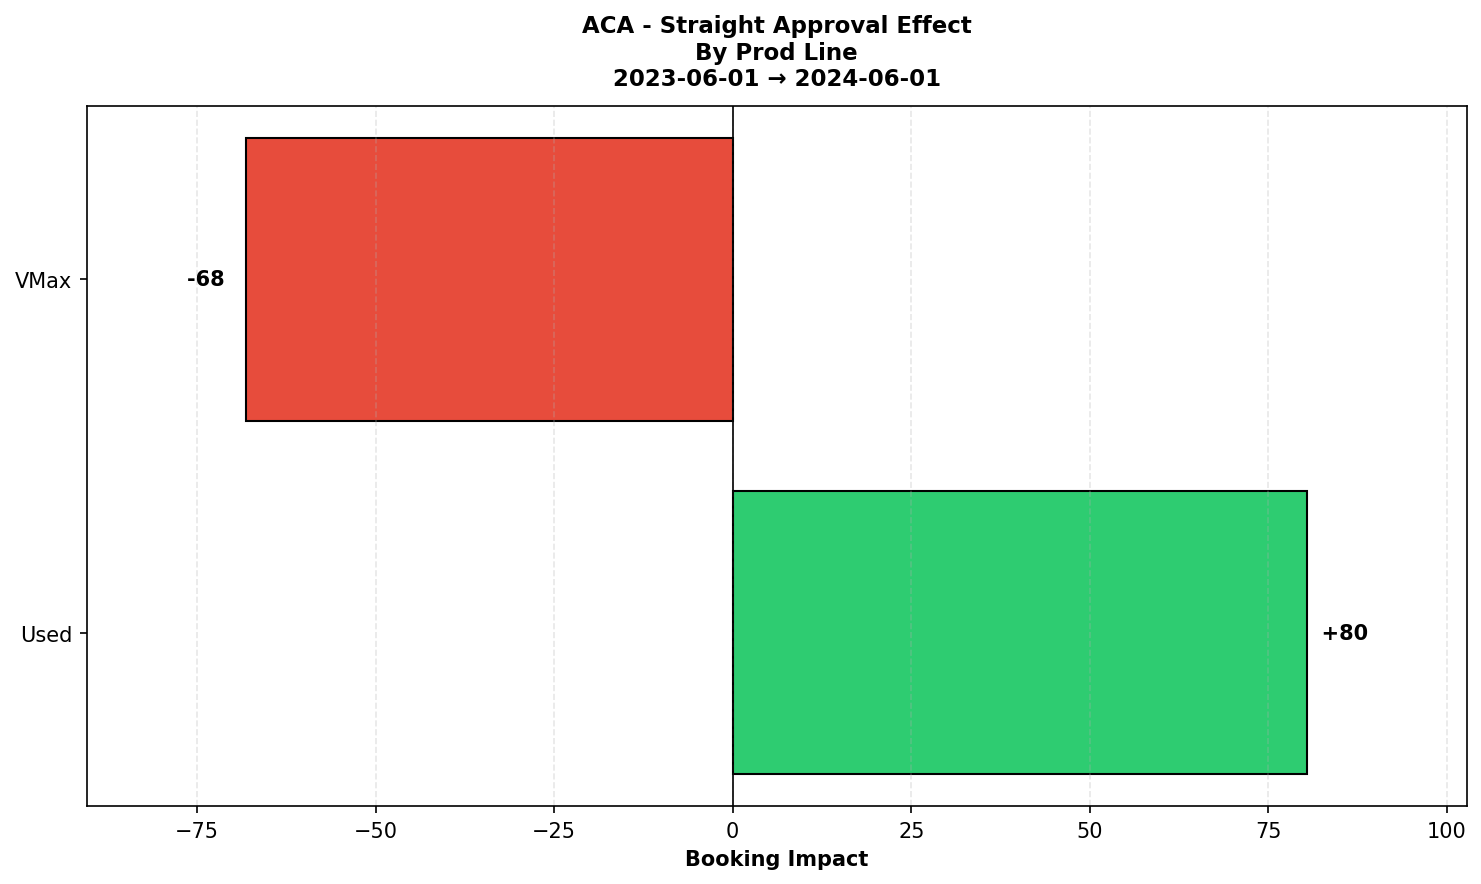

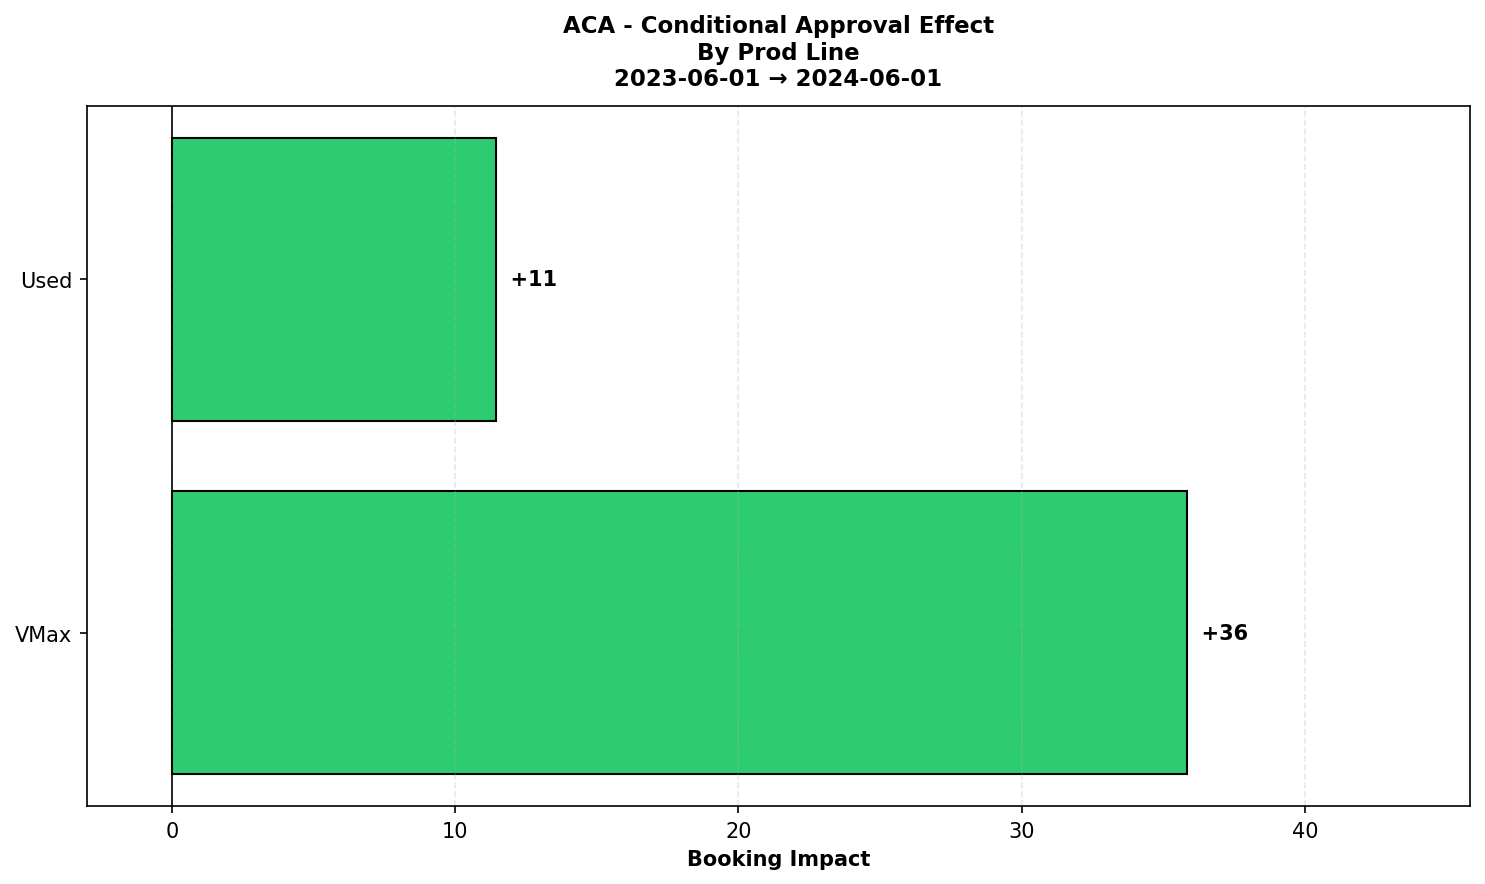

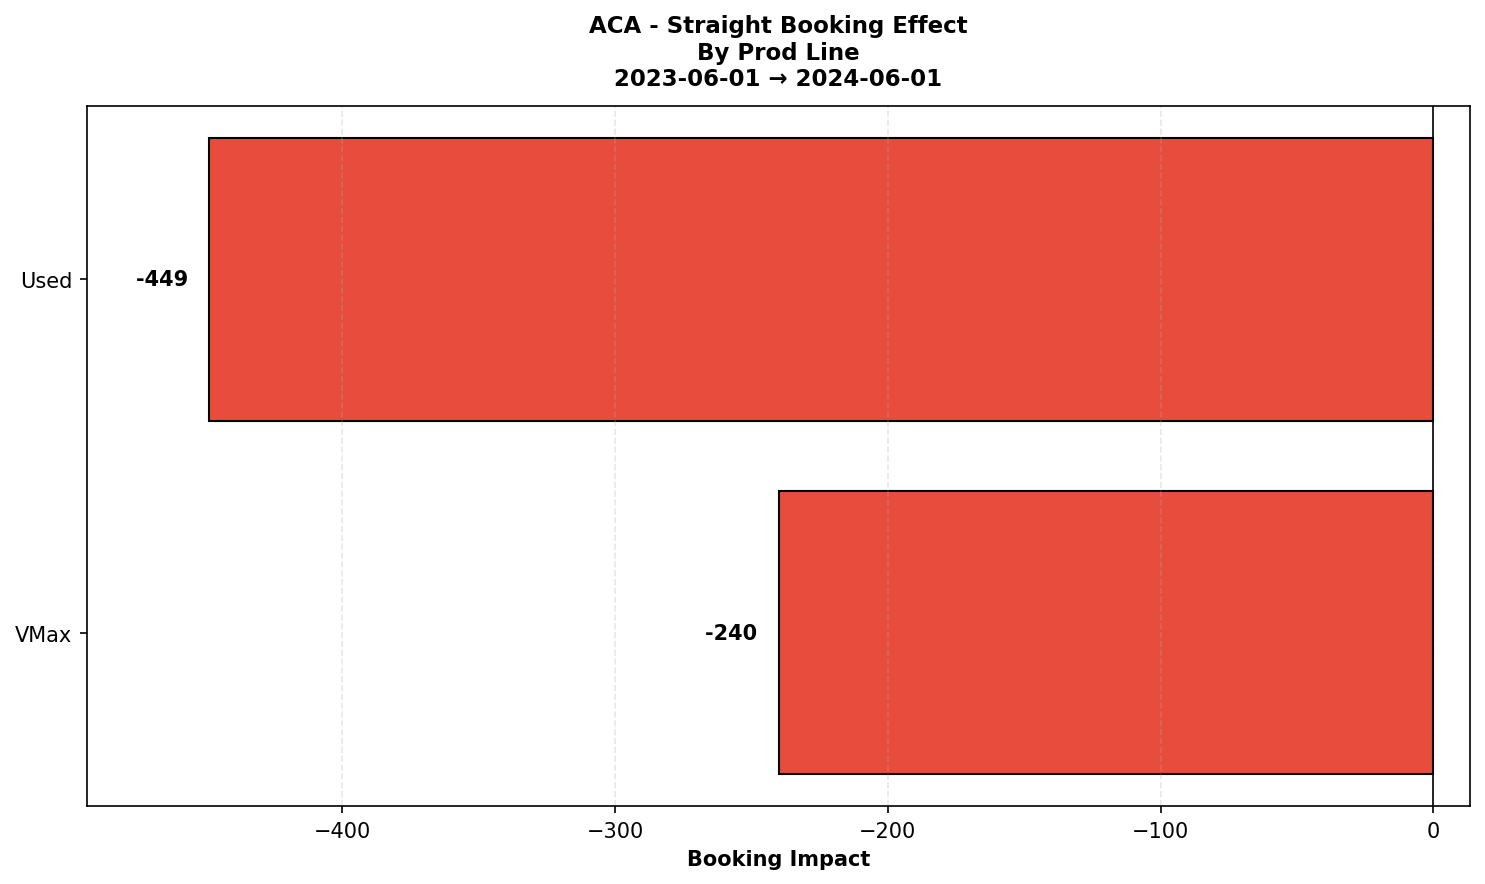

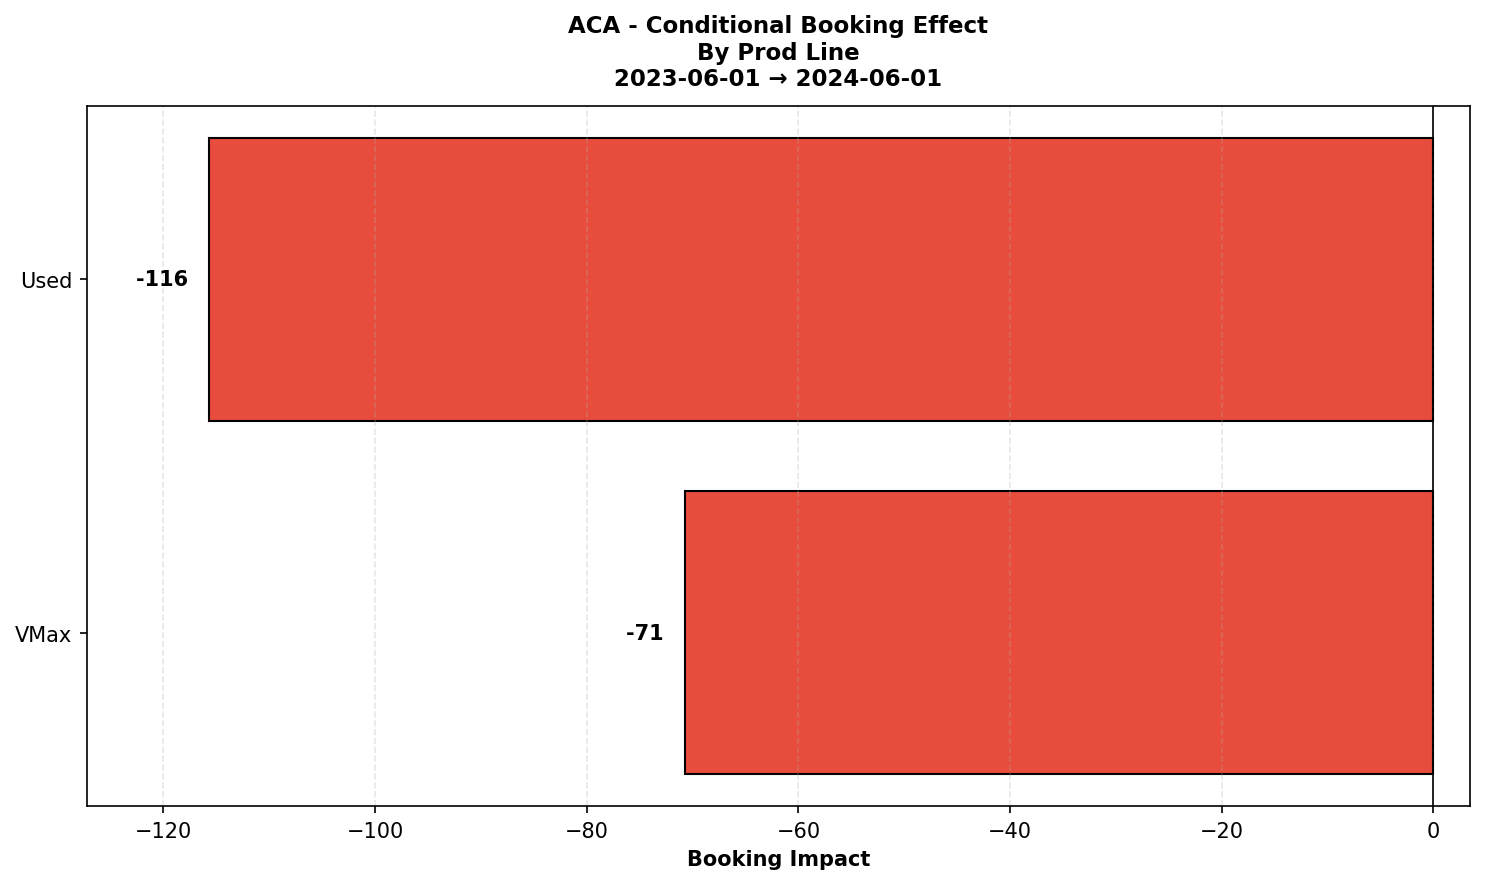

In [11]:
# Extract charts for all dimensions
all_dimension_charts = {}

for dimension in ['fico_bands', 'offer_comp_tier', 'prod_line']:
    charts = extract_individual_drilldown_charts(
        segment_detail=results.segment_detail,
        dimension=dimension,
        lender='ACA'
    )
    all_dimension_charts[dimension] = charts
    print(f"Extracted {len(charts)} charts for {dimension}")

print(f"\nTotal charts extracted: {sum(len(v) for v in all_dimension_charts.values())}")
print("\nAccess charts via:")
print("  all_dimension_charts['fico_bands'][0]  # First FICO effect chart")
print("  all_dimension_charts['offer_comp_tier'][3]  # Comp tier straight approval")
print("  all_dimension_charts['prod_line'][6]  # Product line cond booking")

## 7. Example: Multi-Lender Charts

Extract individual charts from multi-lender analysis.

Extracted 2 charts from lender grid:
  [0] Overall Aggregate
  [1] By Lender (stacked)


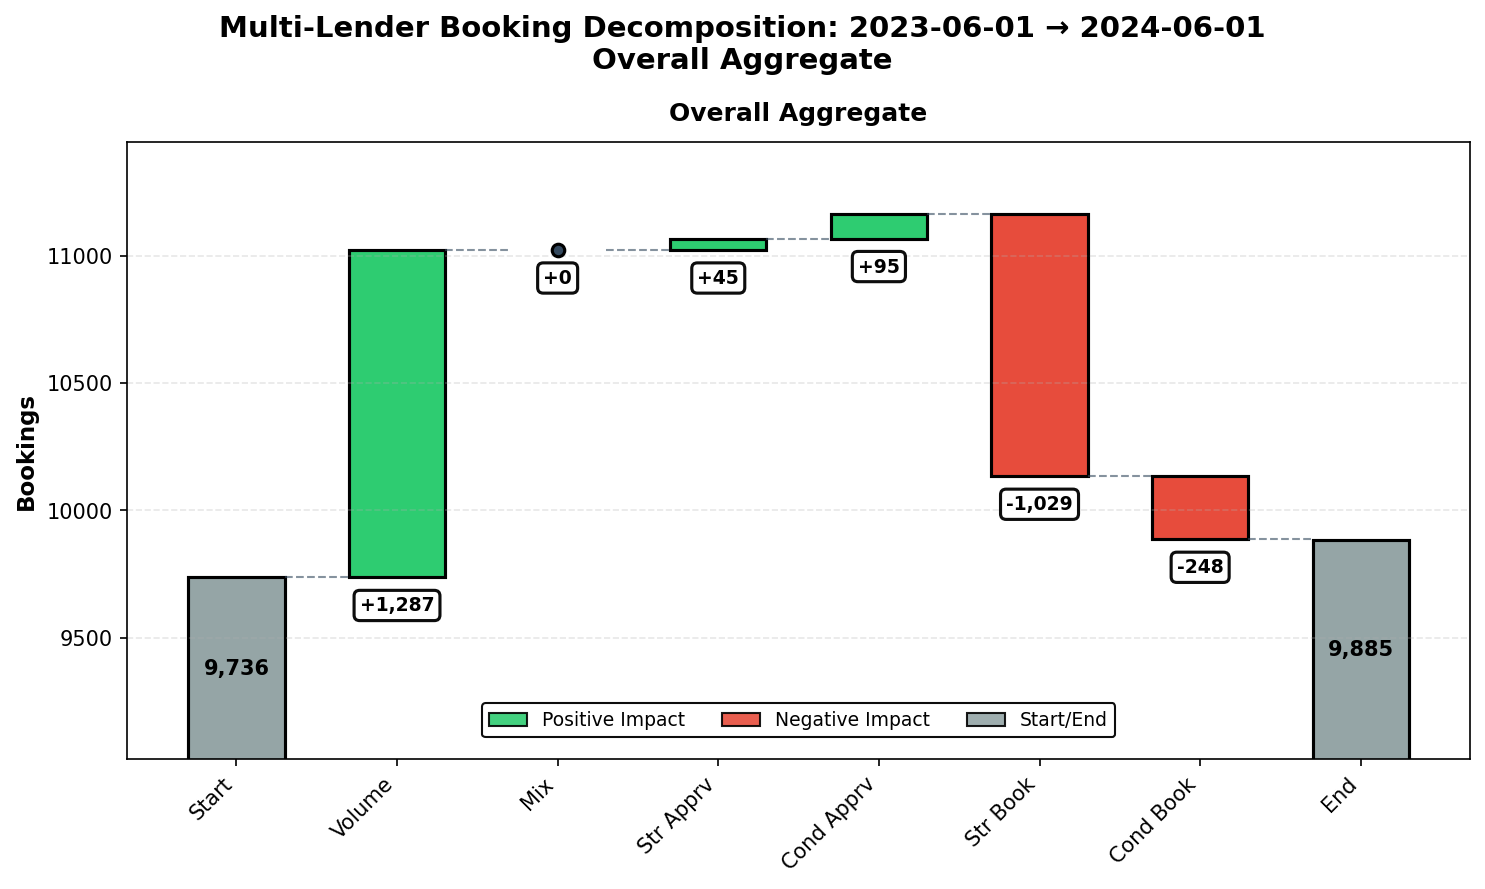

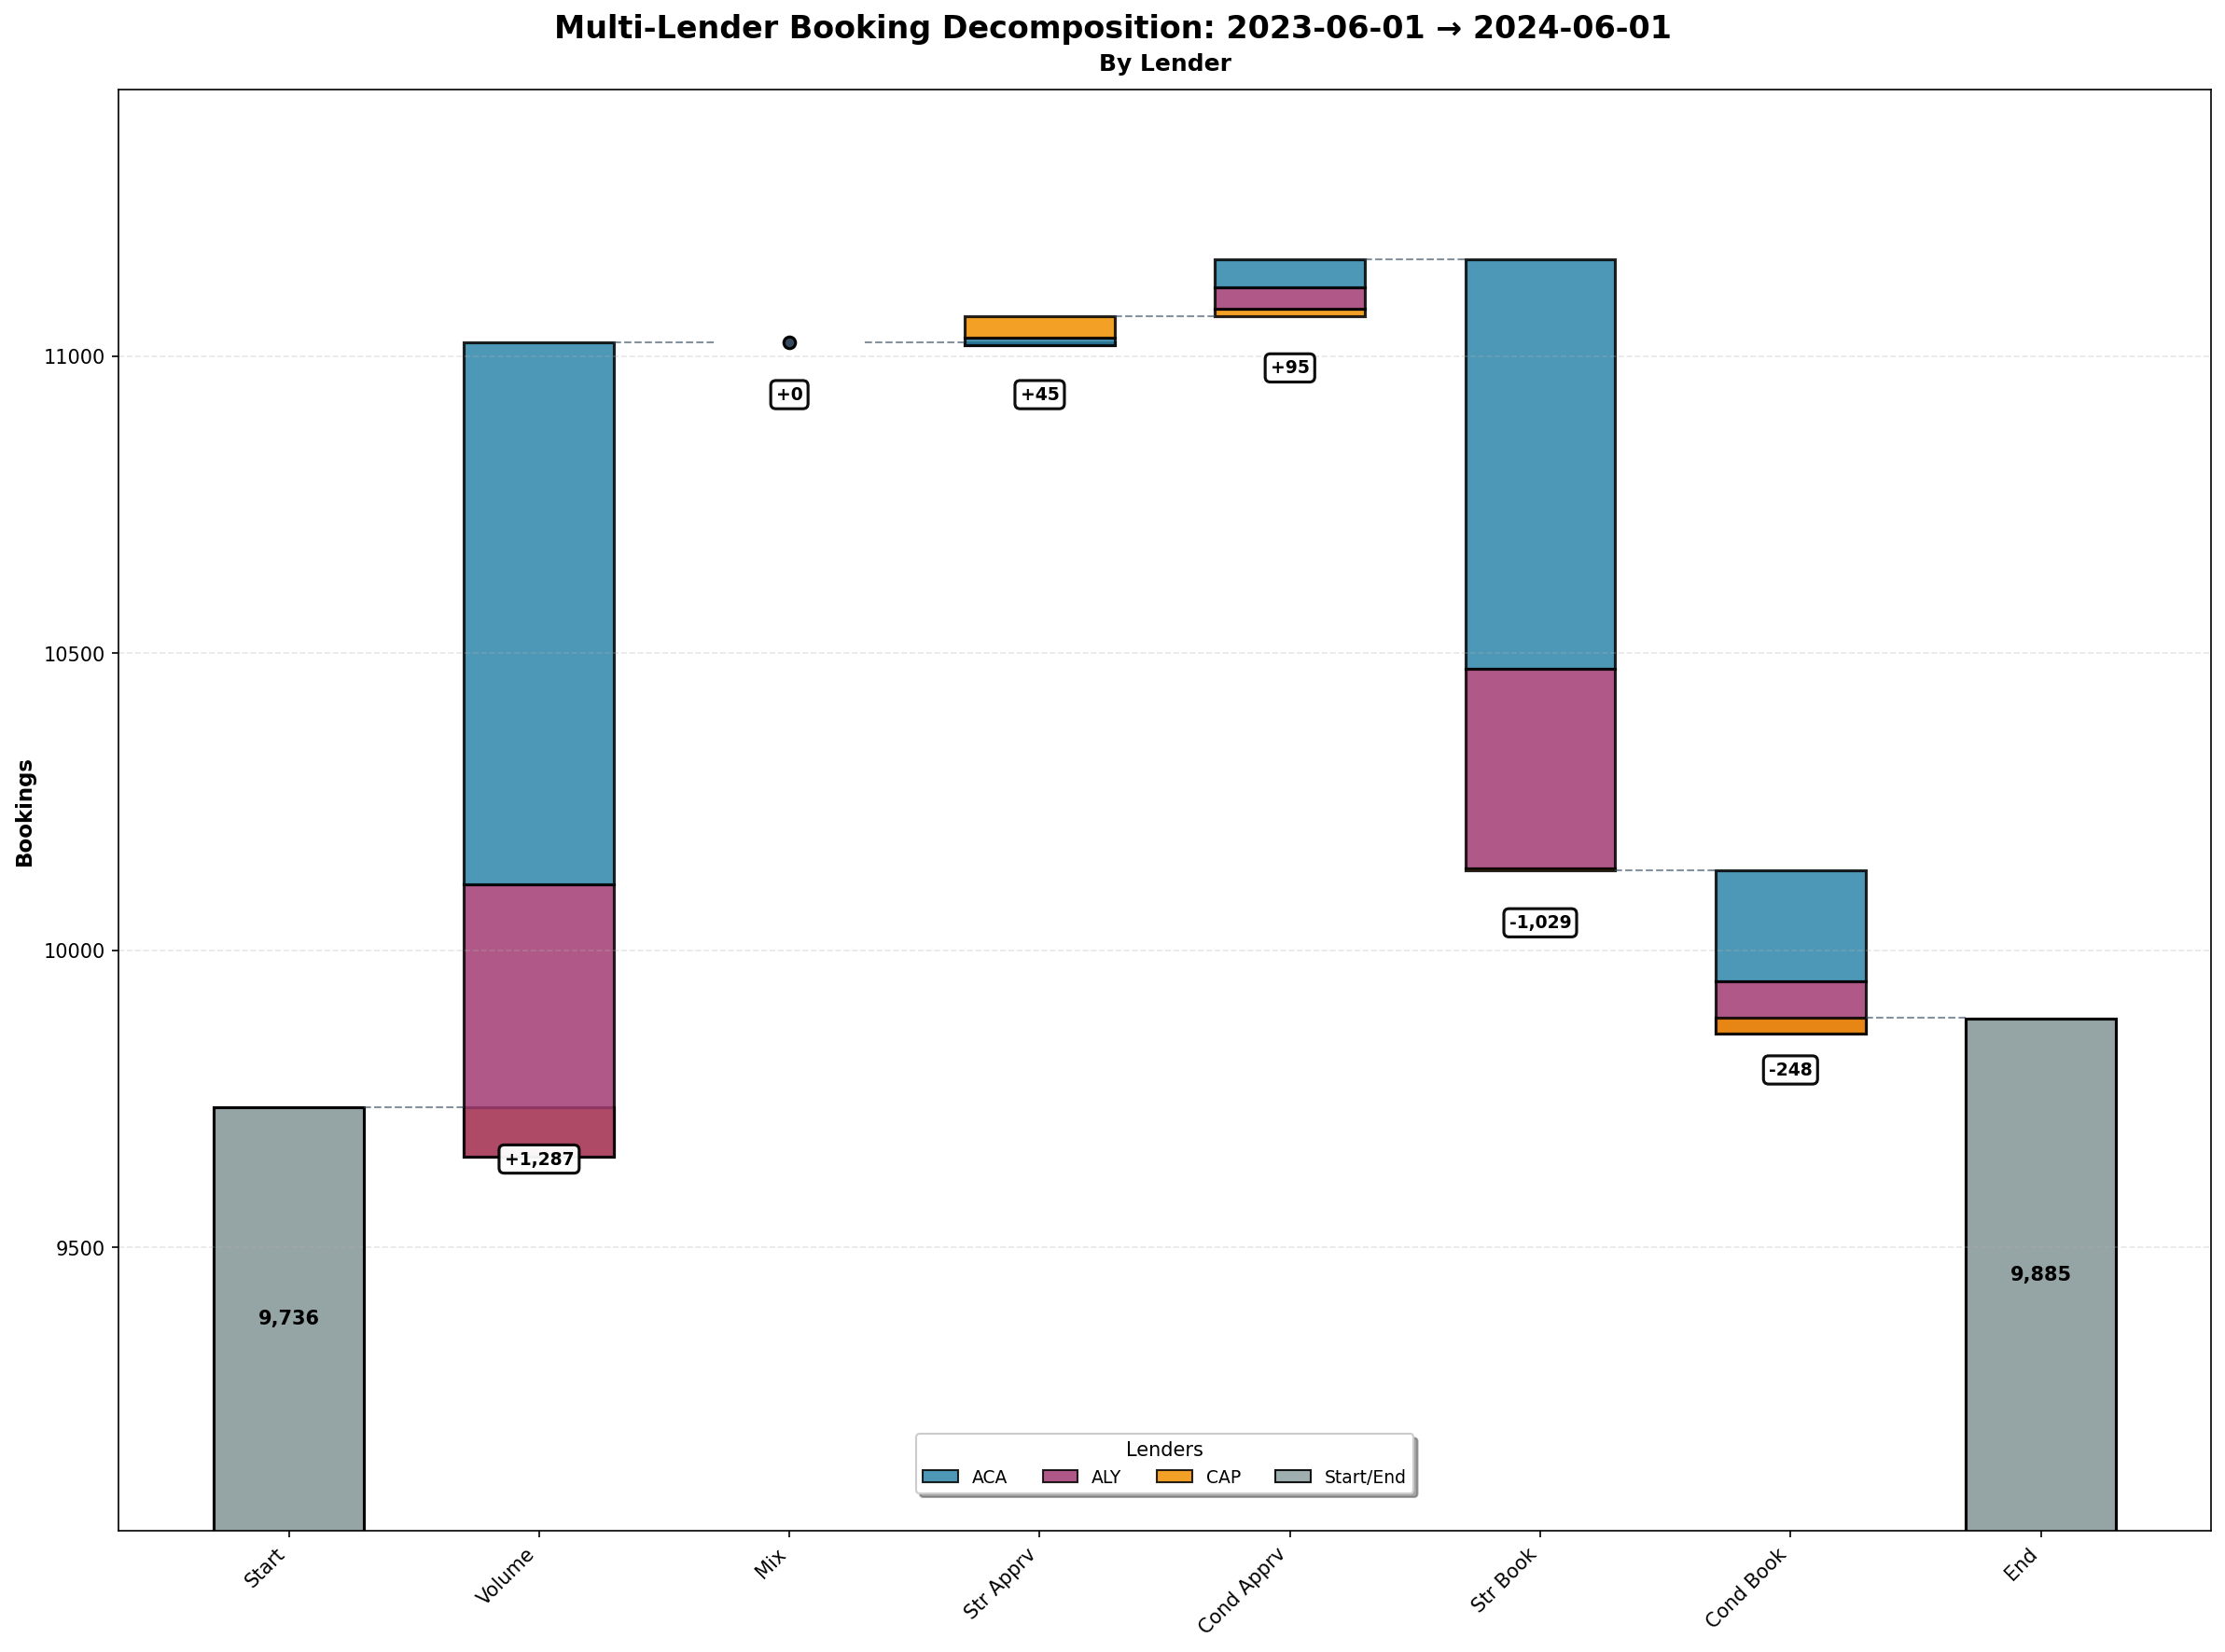

In [12]:
# Extract lender grid charts (2 charts: aggregate + by lender)
lender_grid_charts = extract_lender_grid_charts(
    lender_summaries=multi_results.lender_summaries,
    aggregate_summary=multi_results.aggregate_summary,
    metadata=multi_results.metadata
)

print(f"Extracted {len(lender_grid_charts)} charts from lender grid:")
print("  [0] Overall Aggregate")
print("  [1] By Lender (stacked)")

In [13]:
# Display lender grid charts
for i, chart in enumerate(lender_grid_charts):
    plt.figure(chart.number)
    plt.show()

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

/tmp/ipykernel_653881/3095661717.py:321: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-x_max, x_max)


Extracted 6 lender drilldown charts:
  [0] Volume Effect
  [1] Mix Effect
  [2] Straight Approval Effect
  [3] Conditional Approval Effect
  [4] Straight Booking Effect
  [5] Conditional Booking Effect


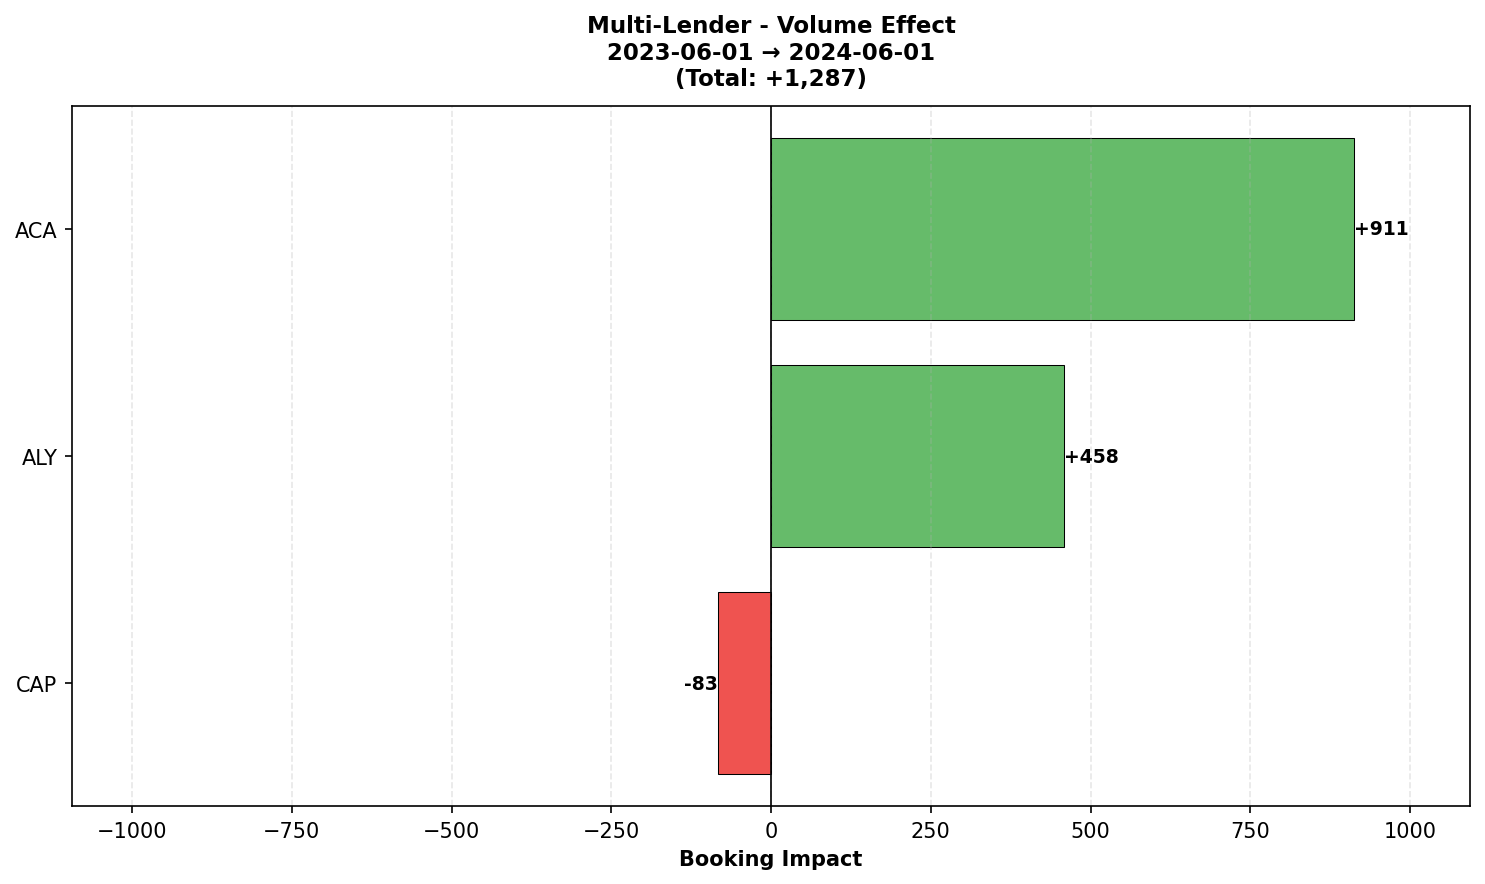

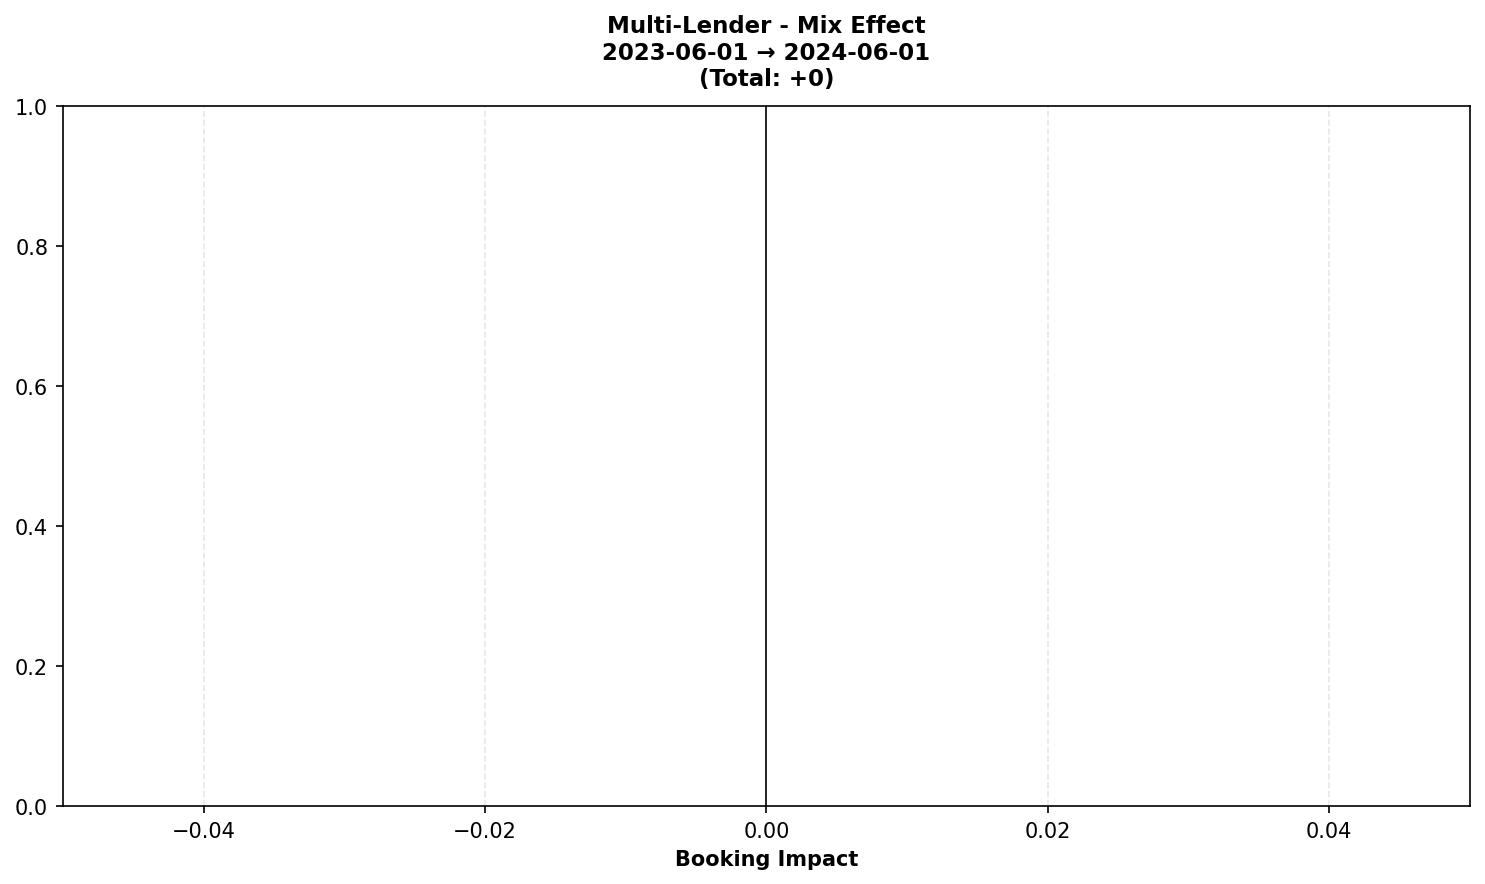

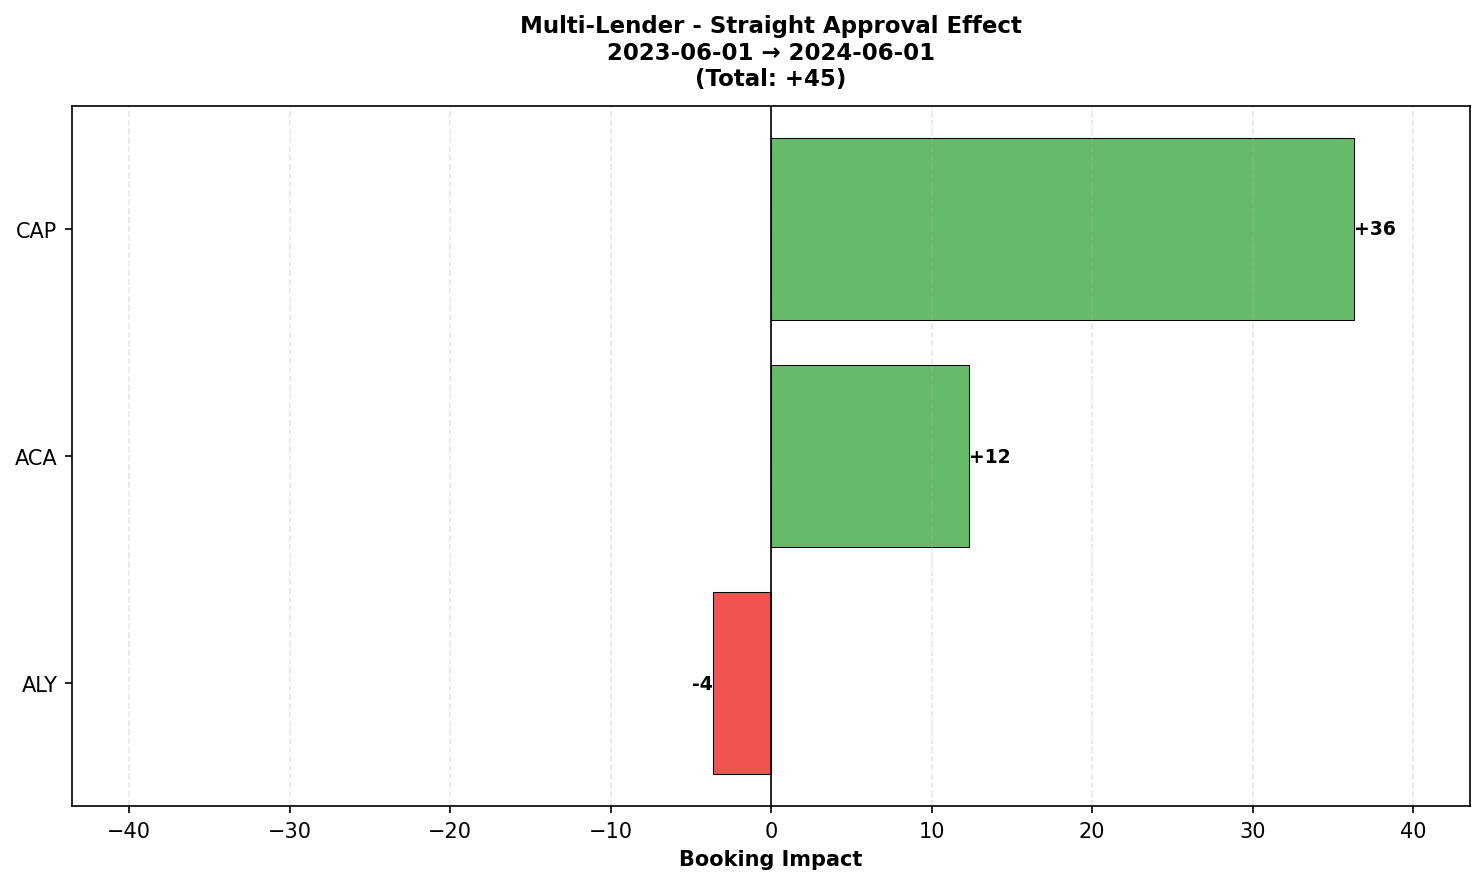

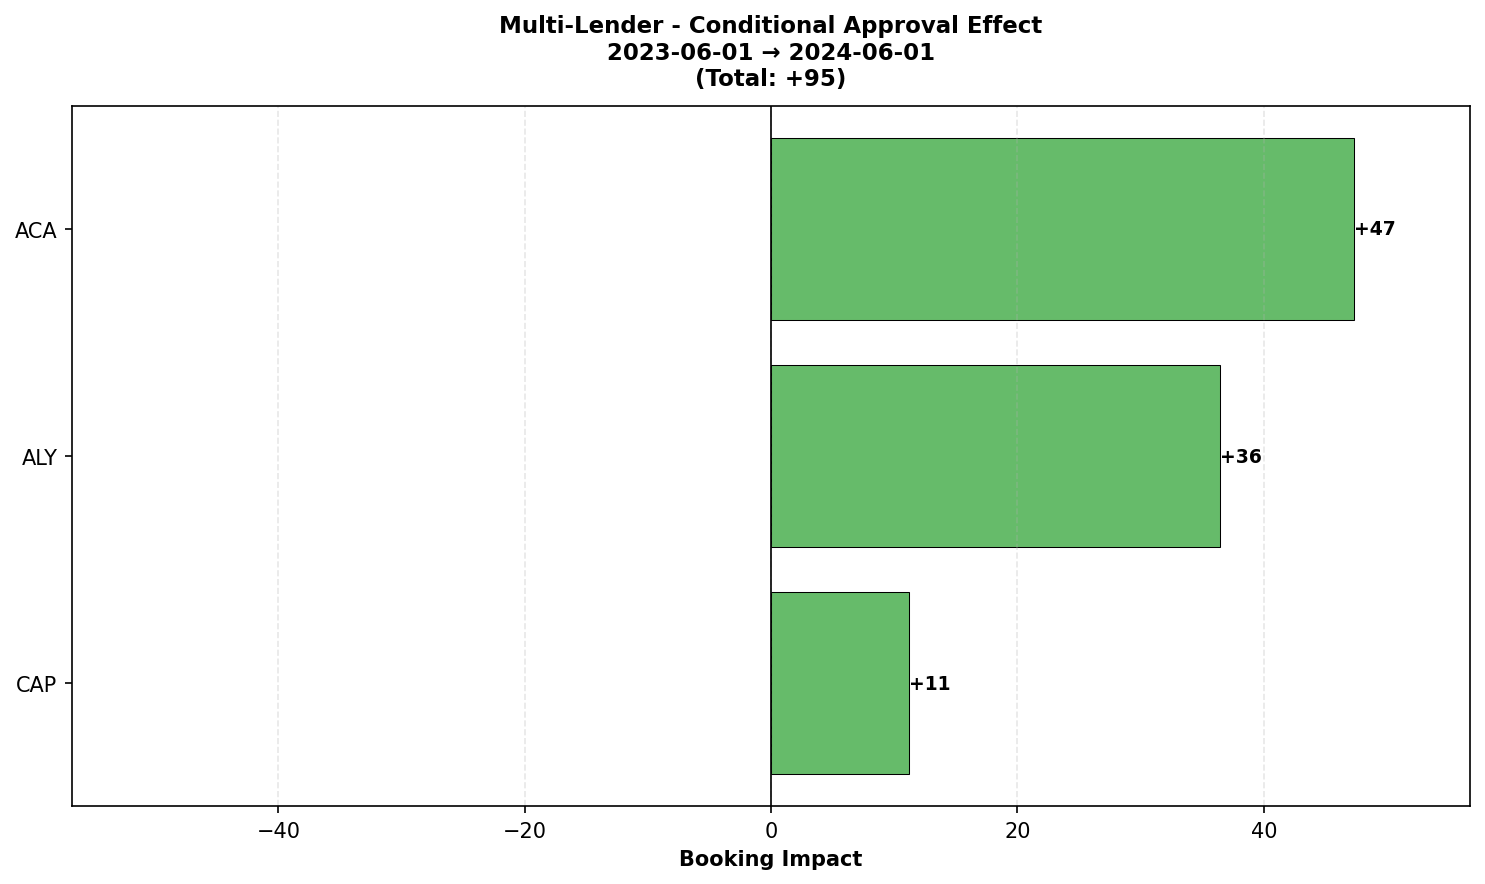

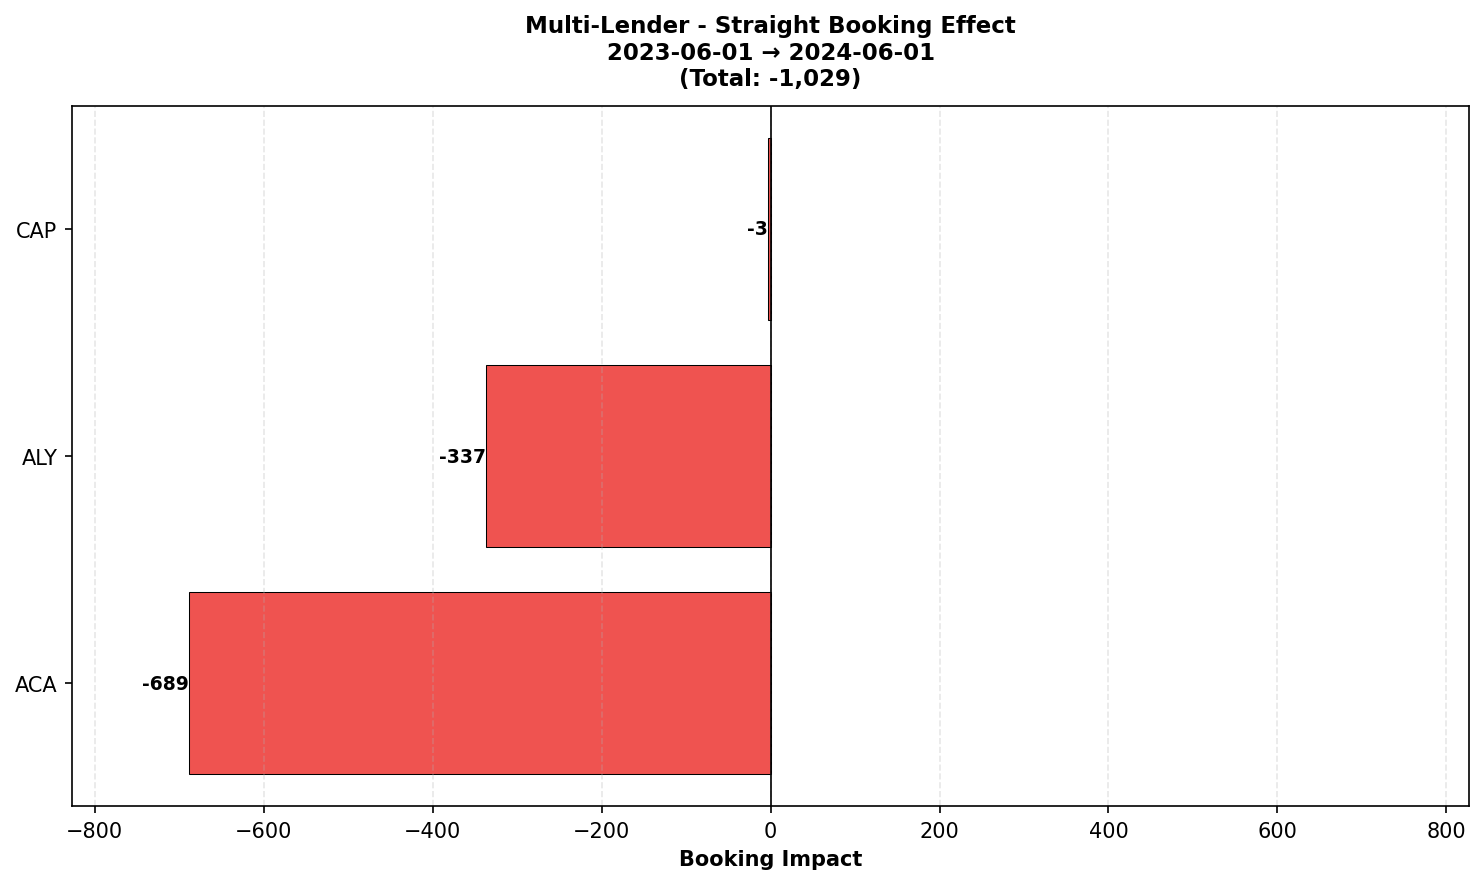

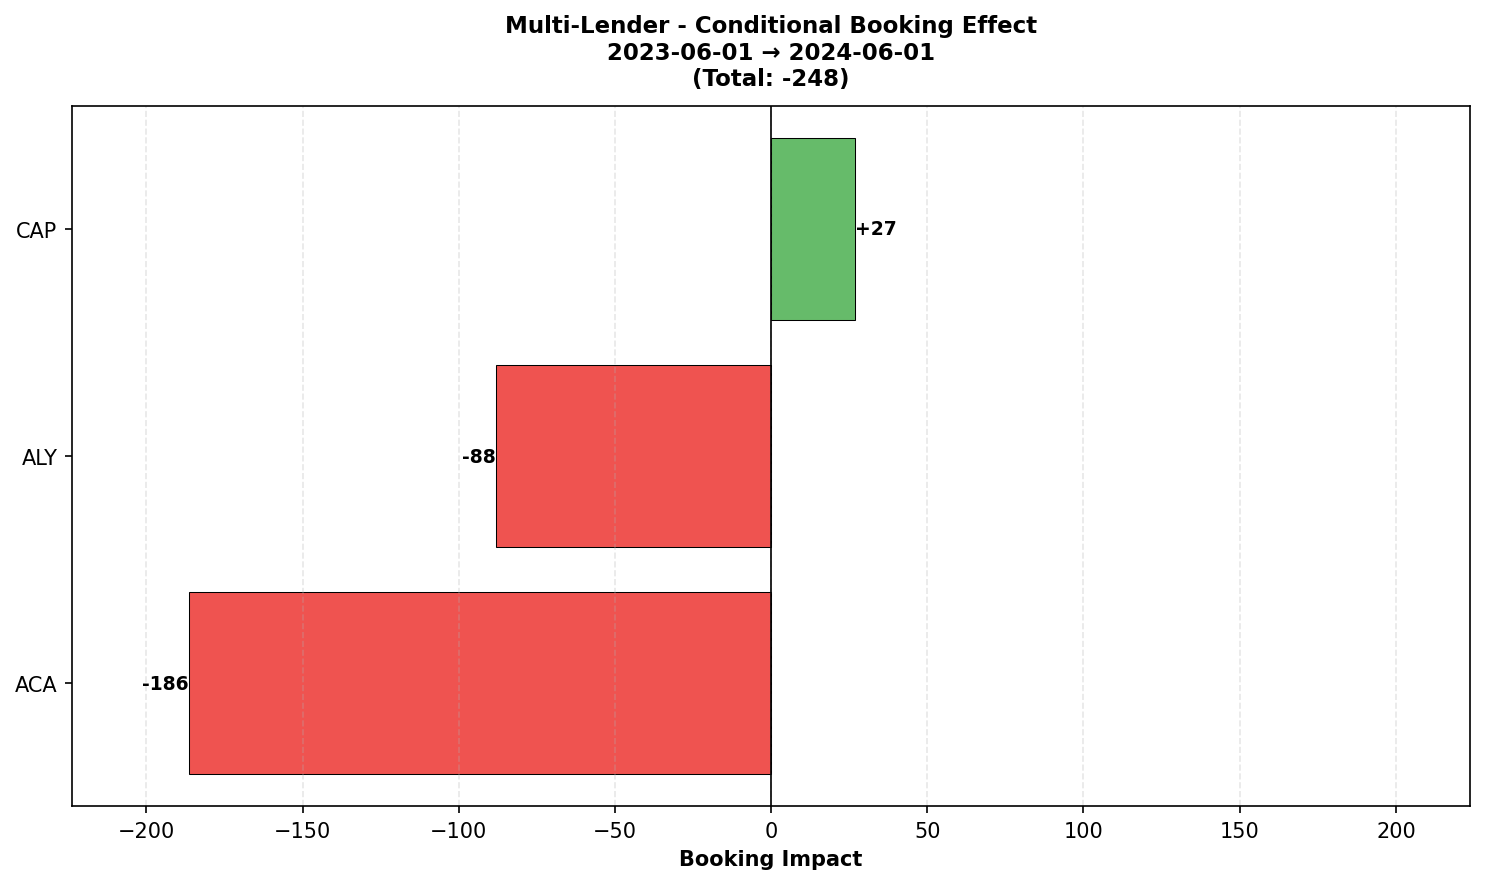

In [14]:
# Extract lender drilldown charts (6 charts, one per effect)
lender_drilldown_charts = extract_lender_drilldown_charts(
    lender_summaries=multi_results.lender_summaries,
    date_a=multi_results.metadata['date_a'],
    date_b=multi_results.metadata['date_b']
)

print(f"Extracted {len(lender_drilldown_charts)} lender drilldown charts:")
print("  [0] Volume Effect")
print("  [1] Mix Effect")
print("  [2] Straight Approval Effect")
print("  [3] Conditional Approval Effect")
print("  [4] Straight Booking Effect")
print("  [5] Conditional Booking Effect")

In [15]:
# Display lender drilldown charts
for i, chart in enumerate(lender_drilldown_charts):
    plt.figure(chart.number)
    plt.show()

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

## 8. Batch Export All Charts

Export all charts at once with organized naming.

In [16]:
def export_all_charts(
    results,
    multi_results=None,
    output_dir='../output/charts',
    dpi=300
):
    """
    Export all chart types to organized directory structure.
    
    Parameters
    ----------
    results : DecompositionResults
        Single-lender decomposition results
    multi_results : MultiLenderDecompositionResults, optional
        Multi-lender decomposition results
    output_dir : str
        Base output directory
    dpi : int
        Resolution for exported images
    """
    output_path = Path(output_dir)
    lender = results.metadata['lender']
    
    print("Exporting all charts...\n")
    
    # 1. Waterfall grid (4 charts)
    print("1. Extracting waterfall grid charts...")
    grid_charts = extract_individual_charts_from_grid(
        summary=results.summary,
        segment_detail=results.segment_detail,
        lender=lender
    )
    chart_names = ['aggregate', 'fico_bands', 'offer_comp_tier', 'prod_line']
    for i, (chart, name) in enumerate(zip(grid_charts, chart_names)):
        export_chart(chart, f"waterfall_{name}", output_path / 'waterfall', dpi)
    
    # 2. Dimension drilldowns (3 dimensions × 7 effects = 21 charts)
    print("\n2. Extracting dimension drilldown charts...")
    effect_names = [
        'total_net', 'volume', 'mix',
        'str_approval', 'cond_approval',
        'str_booking', 'cond_booking'
    ]
    
    for dimension in ['fico_bands', 'offer_comp_tier', 'prod_line']:
        print(f"   - {dimension}")
        charts = extract_individual_drilldown_charts(
            segment_detail=results.segment_detail,
            dimension=dimension,
            lender=lender
        )
        for chart, effect_name in zip(charts, effect_names):
            export_chart(
                chart,
                f"drilldown_{dimension}_{effect_name}",
                output_path / 'drilldown' / dimension,
                dpi
            )
    
    # 3. Multi-lender charts (if provided)
    if multi_results is not None:
        print("\n3. Extracting multi-lender charts...")
        
        # Lender grid (2 charts)
        lender_grid = extract_lender_grid_charts(
            lender_summaries=multi_results.lender_summaries,
            aggregate_summary=multi_results.aggregate_summary,
            metadata=multi_results.metadata
        )
        export_chart(lender_grid[0], 'lender_aggregate', output_path / 'multi_lender', dpi)
        export_chart(lender_grid[1], 'lender_stacked', output_path / 'multi_lender', dpi)
        
        # Lender drilldown (6 charts)
        lender_drilldown = extract_lender_drilldown_charts(
            lender_summaries=multi_results.lender_summaries,
            date_a=multi_results.metadata['date_a'],
            date_b=multi_results.metadata['date_b']
        )
        lender_effect_names = [
            'volume', 'mix', 'str_approval',
            'cond_approval', 'str_booking', 'cond_booking'
        ]
        for chart, effect_name in zip(lender_drilldown, lender_effect_names):
            export_chart(
                chart,
                f"lender_drilldown_{effect_name}",
                output_path / 'multi_lender' / 'drilldown',
                dpi
            )
    
    print("\n" + "="*60)
    print("Export complete!")
    print(f"Charts saved to: {output_path}")
    print("="*60)


# Example: Export all charts
# Uncomment to run:
# export_all_charts(results, multi_results, output_dir='../output/charts', dpi=300)

print("Batch export function defined!")
print("\nTo export all charts, run:")
print("  export_all_charts(results, multi_results)")

Batch export function defined!

To export all charts, run:
  export_all_charts(results, multi_results)


## 9. Summary of Available Chart Lists

Quick reference for accessing individual charts.

In [17]:
# Summary of all available chart lists
print("AVAILABLE CHART LISTS")
print("="*60)
print("\n1. WATERFALL GRID (4 charts):")
print("   grid_charts = extract_individual_charts_from_grid(...)")
print("   [0] Overall Aggregate")
print("   [1] By FICO Bands")
print("   [2] By Offer Comp Tier")
print("   [3] By Product Line")

print("\n2. DIMENSION DRILLDOWNS (7 charts per dimension):")
print("   fico_charts = extract_individual_drilldown_charts(..., 'fico_bands', ...)")
print("   comp_charts = extract_individual_drilldown_charts(..., 'offer_comp_tier', ...)")
print("   prod_charts = extract_individual_drilldown_charts(..., 'prod_line', ...)")
print("   [0] Total Net Impact")
print("   [1] Volume Effect")
print("   [2] Mix Effect")
print("   [3] Straight Approval Effect")
print("   [4] Conditional Approval Effect")
print("   [5] Straight Booking Effect")
print("   [6] Conditional Booking Effect")

print("\n3. LENDER GRID (2 charts):")
print("   lender_grid = extract_lender_grid_charts(...)")
print("   [0] Overall Aggregate")
print("   [1] By Lender (stacked)")

print("\n4. LENDER DRILLDOWN (6 charts):")
print("   lender_drill = extract_lender_drilldown_charts(...)")
print("   [0] Volume Effect")
print("   [1] Mix Effect")
print("   [2] Straight Approval Effect")
print("   [3] Conditional Approval Effect")
print("   [4] Straight Booking Effect")
print("   [5] Conditional Booking Effect")

print("\n" + "="*60)
print("TOTAL UNIQUE CHARTS: 35")
print("  - Waterfall Grid: 4")
print("  - Dimension Drilldowns: 21 (3 dimensions × 7 effects)")
print("  - Lender Grid: 2")
print("  - Lender Drilldown: 6")
print("  - Plus 2 standalone formats available")
print("="*60)

AVAILABLE CHART LISTS

1. WATERFALL GRID (4 charts):
   grid_charts = extract_individual_charts_from_grid(...)
   [0] Overall Aggregate
   [1] By FICO Bands
   [2] By Offer Comp Tier
   [3] By Product Line

2. DIMENSION DRILLDOWNS (7 charts per dimension):
   fico_charts = extract_individual_drilldown_charts(..., 'fico_bands', ...)
   comp_charts = extract_individual_drilldown_charts(..., 'offer_comp_tier', ...)
   prod_charts = extract_individual_drilldown_charts(..., 'prod_line', ...)
   [0] Total Net Impact
   [1] Volume Effect
   [2] Mix Effect
   [3] Straight Approval Effect
   [4] Conditional Approval Effect
   [5] Straight Booking Effect
   [6] Conditional Booking Effect

3. LENDER GRID (2 charts):
   lender_grid = extract_lender_grid_charts(...)
   [0] Overall Aggregate
   [1] By Lender (stacked)

4. LENDER DRILLDOWN (6 charts):
   lender_drill = extract_lender_drilldown_charts(...)
   [0] Volume Effect
   [1] Mix Effect
   [2] Straight Approval Effect
   [3] Conditional Approv

## 10. Quick Export Examples

In [18]:
# Example 1: Export just the aggregate waterfall
# export_chart(grid_charts[0], 'aggregate_waterfall')

# Example 2: Export all FICO drilldown charts
# export_chart_list(fico_drilldown_charts, 'fico_drilldown')

# Example 3: Export a specific effect chart
# export_chart(fico_drilldown_charts[1], 'fico_volume_effect')

# Example 4: Export all multi-lender charts
# export_chart_list(lender_grid_charts + lender_drilldown_charts, 'multi_lender')

# Example 5: Export everything
# export_all_charts(results, multi_results, output_dir='../output/charts', dpi=300)

print("Examples ready! Uncomment any line above to export.")

Examples ready! Uncomment any line above to export.
